# Проект "Промышленность"

## Описание проекта и задачи

Цель проекта - разработка модели машинного обучения для предсказания температуры в сталеплавильном ковше в процессе выплавки стали.Эти предсказания могут быть использованы для оптимизации производственного процесса и сокращения издержек на энергопотребление.

<b>Описание этапа обработки</b>

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

<b>Описание данных</b>

Данные состоят из файлов, полученных из разных источников:

- data_arc_new.csv — данные об электродах;
- data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
- data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
- data_gas_new.csv — данные о продувке сплава газом;
- data_temp_new.csv — результаты измерения температуры;
- data_wire_new.csv — данные о проволочных материалах (объём);
- data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

<b>План работы</b>

1. Описание проекта, задачи

2. Изучение и подготовка данных:

- Выгрузка данных;
- Анализ данных;

3. Исследовательский анализ данных:

- Проверка типов данных;
- Работа с проспусками;
- Работа с выбросами;
- Формирование дополнительных признаков;
- Формирование итоговых датафреймов;
- Проверка на мультиколлинеарность.

4. Обучение моделей:

- Формирование целевого и остальных признаков;
- Формирвоание обучающих, валид и тест выборок;
- 3 модели.

5. Тестирование модели:

- Анализ важности факторов.

6. Итоговый вывод

## Изучение и подготовка данных

In [1]:
!pip install shap --user

In [2]:
!pip install optuna --user

In [3]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold)
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
shap.initjs()

from sklearn.pipeline import Pipeline



RANDOM_STATE = 12923


<b>Данные об электродах</b>

In [5]:

data_arc = pd.read_csv('data_arc_new.csv')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


In [7]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<b>Данные о подаче сыпучих материалов (объём)</b>

In [8]:

data_bulk_new = pd.read_csv('data_bulk_new.csv')
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [10]:
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<b>Данные о подаче сыпучих материалов (время)</b>

In [11]:

data_bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [12]:
data_bulk_time_new.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


In [13]:
data_bulk_time_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


<b>Данные о продувке сплава газом</b>

In [14]:

data_gas_new = pd.read_csv('data_gas_new.csv')
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [15]:
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


In [16]:
data_gas_new.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<b>Результаты измерения температуры</b>

In [17]:

data_temp_new = pd.read_csv('data_temp_new.csv')
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [18]:
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


In [19]:
data_temp_new.head()

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


<b>Данные о проволочных материалах (объём)</b>

In [20]:

data_wire_new = pd.read_csv('data_wire_new.csv')
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [21]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [22]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>Данные о проволочных материалах (время)</b>

In [23]:

data_wire_time_new = pd.read_csv('data_wire_time_new.csv')
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [24]:
data_wire_time_new.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


In [25]:
data_wire_time_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные успешнозагружены и открыты. Целевая переменная - значение температуры для каждого ковша на последнем этапе. В данных есть пропуски и выбросы.Данные с датой и временем не будут использоваться, однако другие столбцы можно использовать как доп признаки.

## Исследовательский анализ данных.

<b>Данные об электродах</b>

<AxesSubplot:>

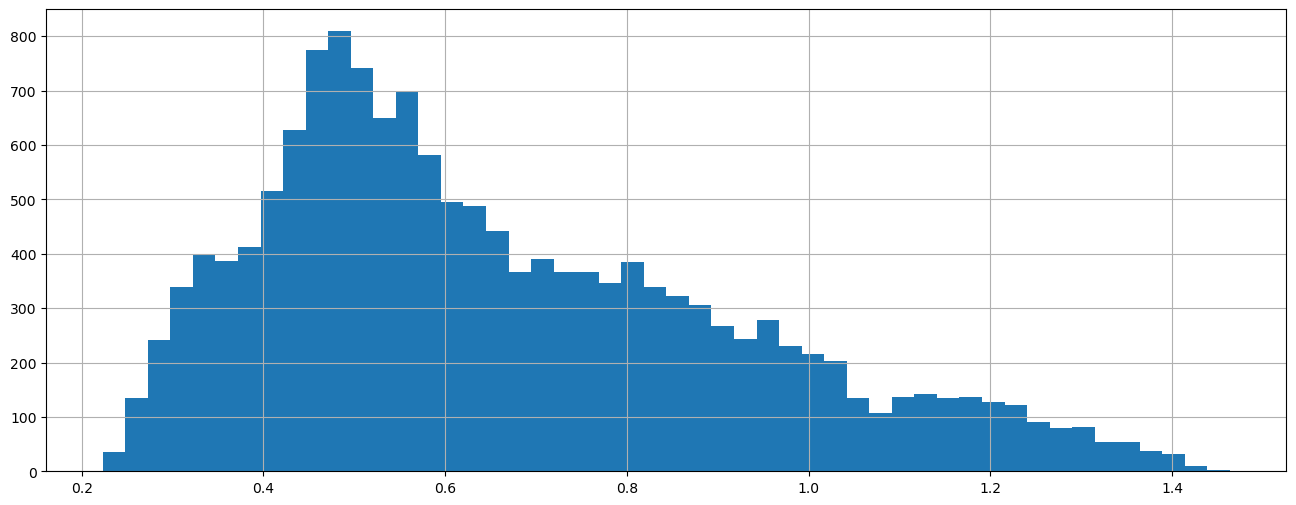

In [26]:
data_arc['Активная мощность'].hist(figsize=(16, 6), bins=50)

<AxesSubplot:>

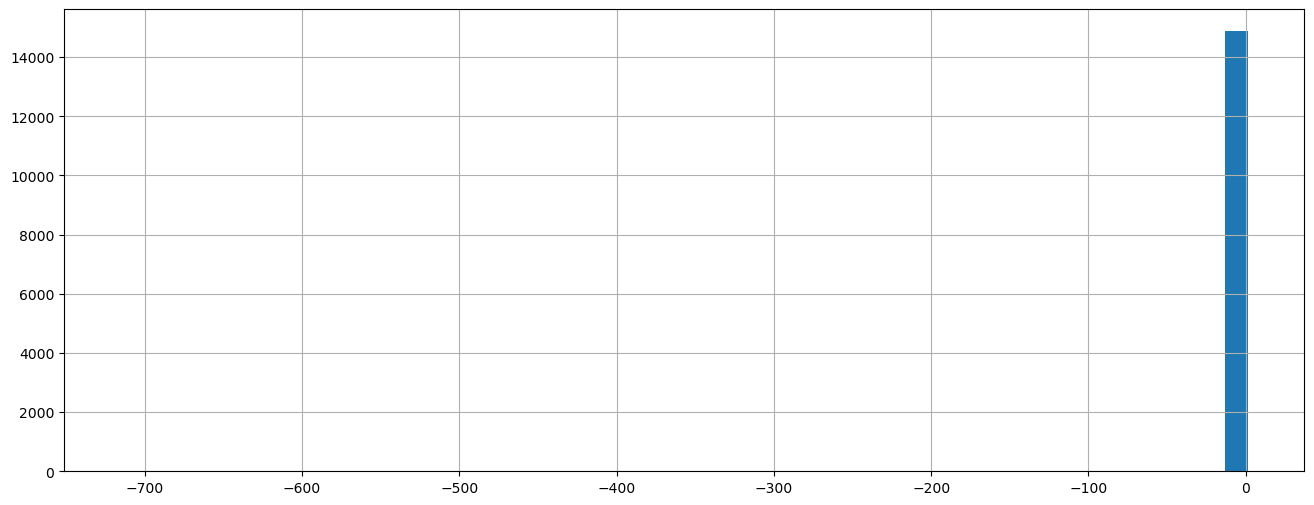

In [27]:
data_arc['Реактивная мощность'].hist(figsize=(16, 6), bins=50)

В данных по реактивной мощности присутствует отрицательное значение.

In [28]:
data_arc[data_arc['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


Его можно удалить, либо заменить на среднее значение.

In [29]:
data_arc.loc[9780, 'Реактивная мощность'] = data_arc['Реактивная мощность'].mean()

<AxesSubplot:>

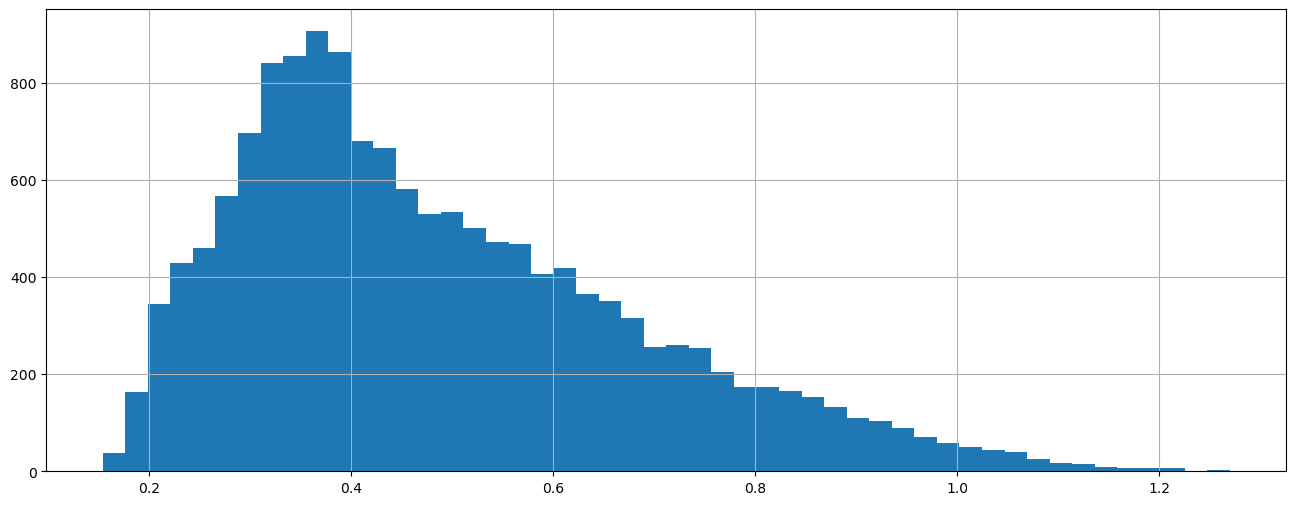

In [30]:
data_arc['Реактивная мощность'].hist(figsize=(16, 6), bins=50)

На графиках с активной и реактивной мощностями мы наблюдаем нормальное распределение с положительным отклонением.

Полная мощность равна: 
$$S=\sqrt{P^2 + Q^2}$$. 
Добавим дополнительный признак:

In [31]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)
Apparent_Power_Sum = data_arc.groupby('key')['Полная мощность'].sum().reset_index()
data_arc = data_arc.merge(Apparent_Power_Sum.rename(columns={'Полная мощность':'Полная мощность сум'}), how='left', on='key')

Дополнительный признак время нагрева:

In [32]:
data_arc['Время нагрева'] = (pd.to_datetime(data_arc['Конец нагрева дугой'])-pd.to_datetime(data_arc['Начало нагрева дугой']))\
                             .dt.total_seconds()
HTime_Sum = data_arc.groupby('key')['Время нагрева'].sum().reset_index()
data_arc = data_arc.merge(HTime_Sum.rename(columns={'Время нагрева':'Общее время нагрева'}), how='left', on='key')

Дополнительный признак Электроэнергия:

In [33]:
data_arc['Электроэнергия'] = data_arc['Полная мощность сум'] * data_arc['Общее время нагрева']

Удалим лишние данные и полные дубликаты.

In [34]:
data_arc = data_arc.drop(['Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность',\
                         'Полная мощность', 'Время нагрева'], axis=1)

In [35]:
data_arc=data_arc.drop_duplicates(subset = ['Полная мощность сум']) 

In [36]:
data_arc.head()

,key,Полная мощность сум,Общее время нагрева,Электроэнергия
0,1,3.718736,1098.0,4083.171936
5,2,2.588349,811.0,2099.150800
9,3,5.019223,655.0,3287.591368
14,4,3.400038,741.0,2519.428170
18,5,2.816980,869.0,2447.955323


<b>Данные о подаче сыпучих материалов (объём)</b>

Пропуски заменим на 0, т.к. они обозначают отсутствие подачи сыпучих материалов.

In [37]:
data_bulk_new=data_bulk_new.fillna(0)
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


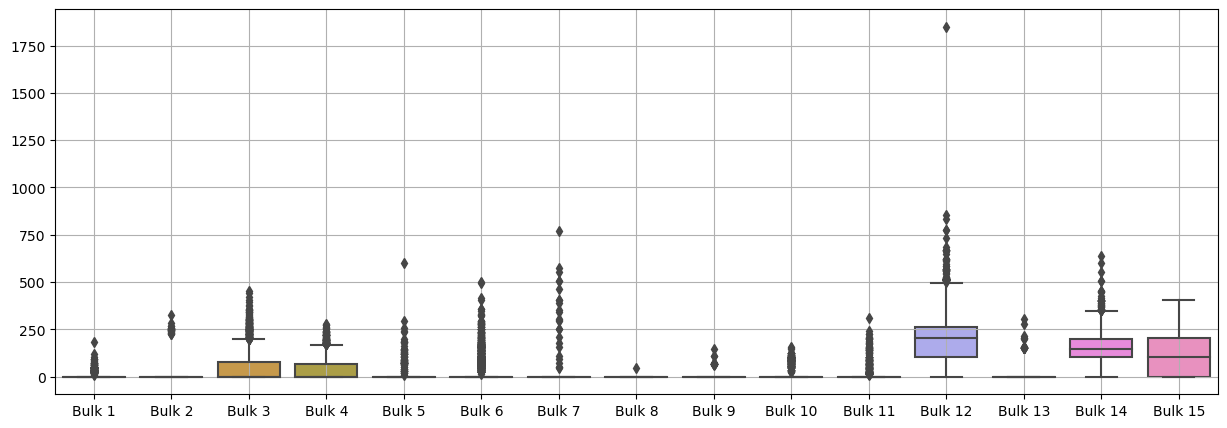

In [38]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_bulk_new.drop('key',axis=1))
plt.grid();

Имеются некоторые выбросы, однако, не будем их трогать, т.к. они характеризуют реальный технологический процесс.

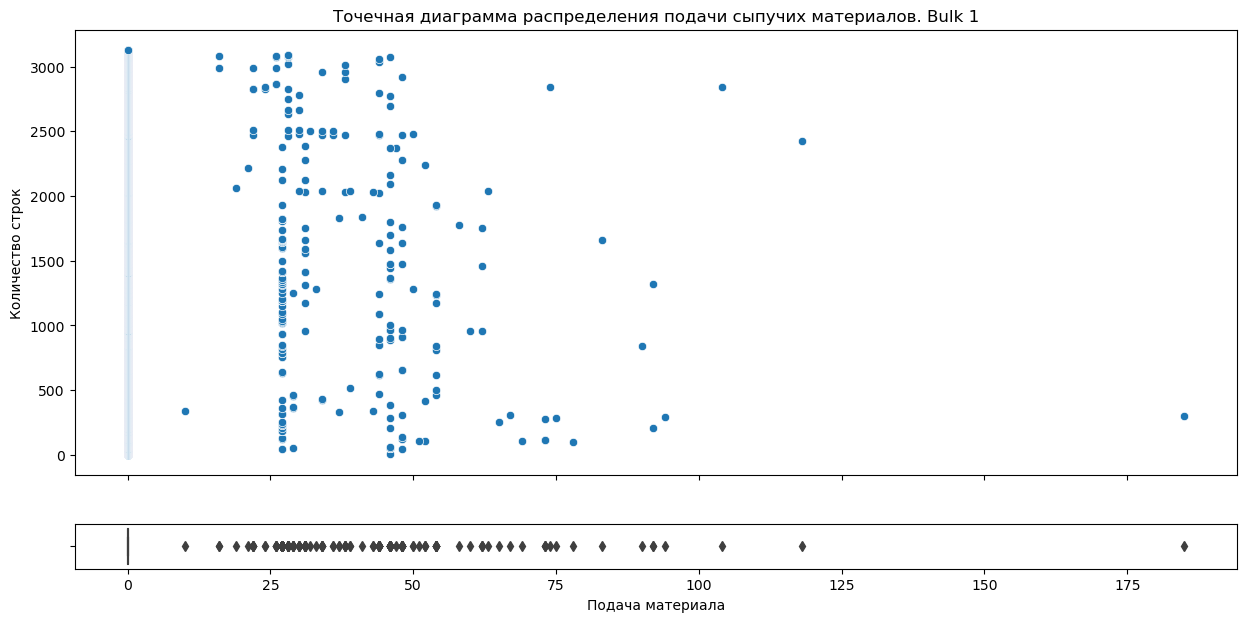

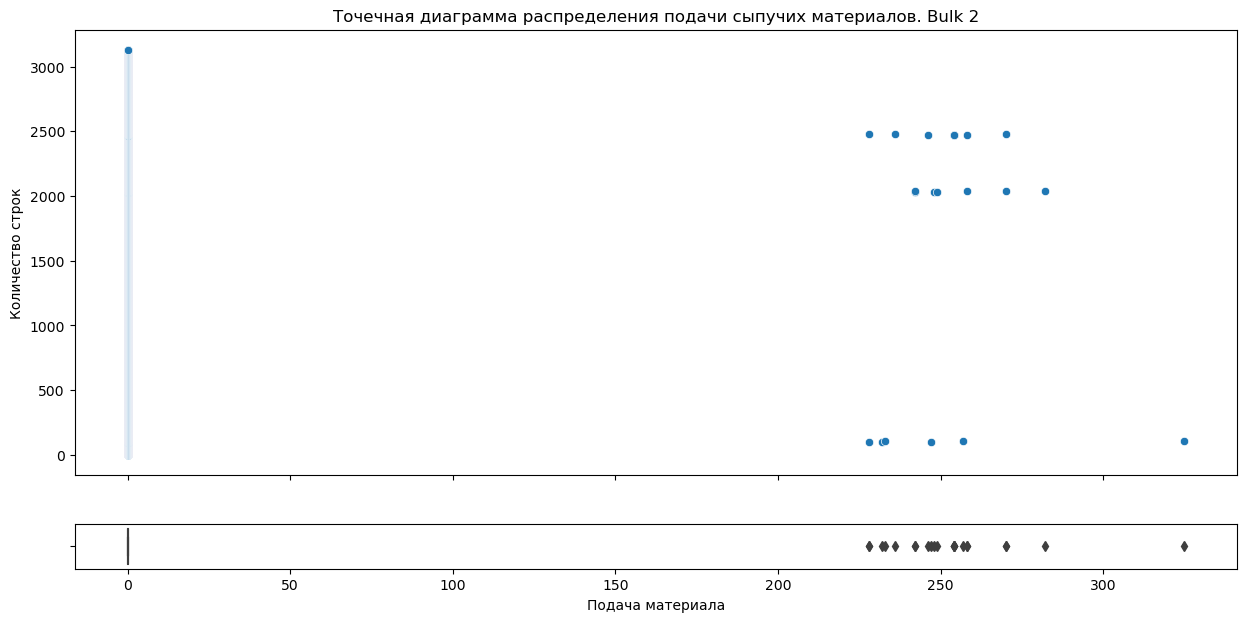

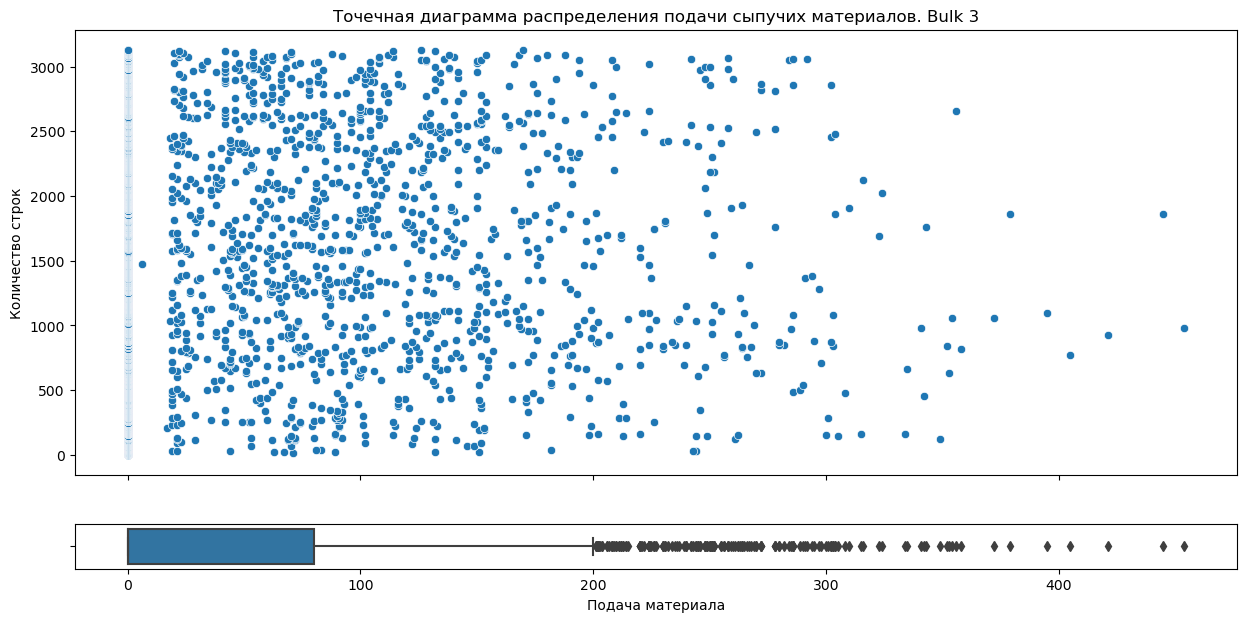

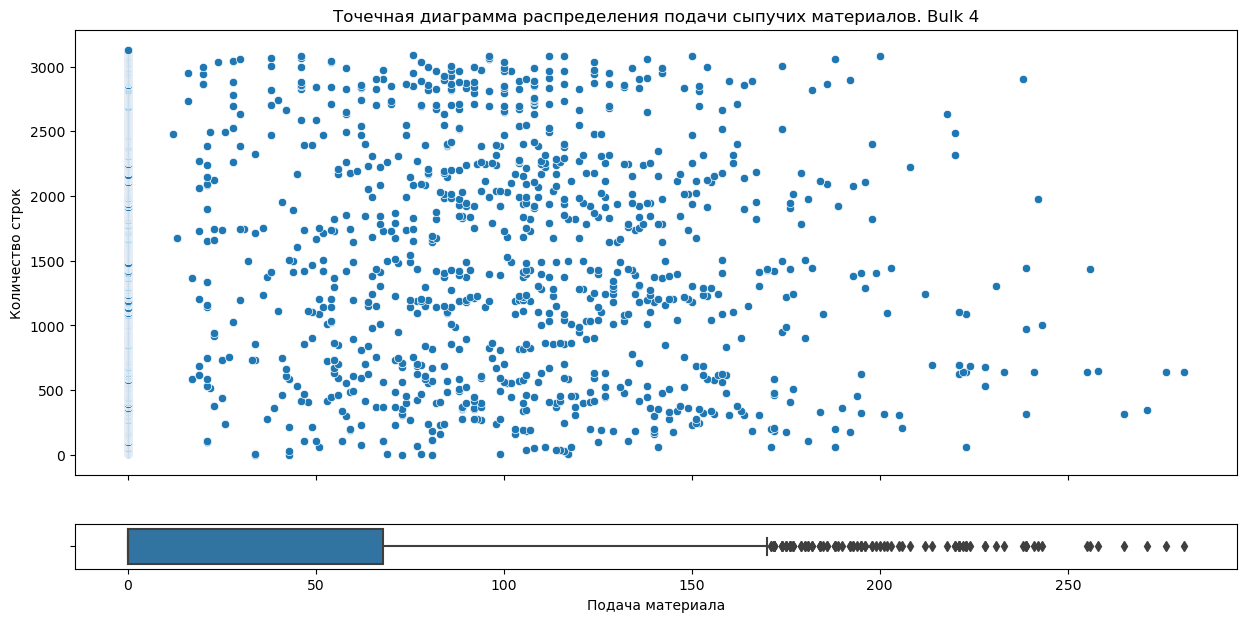

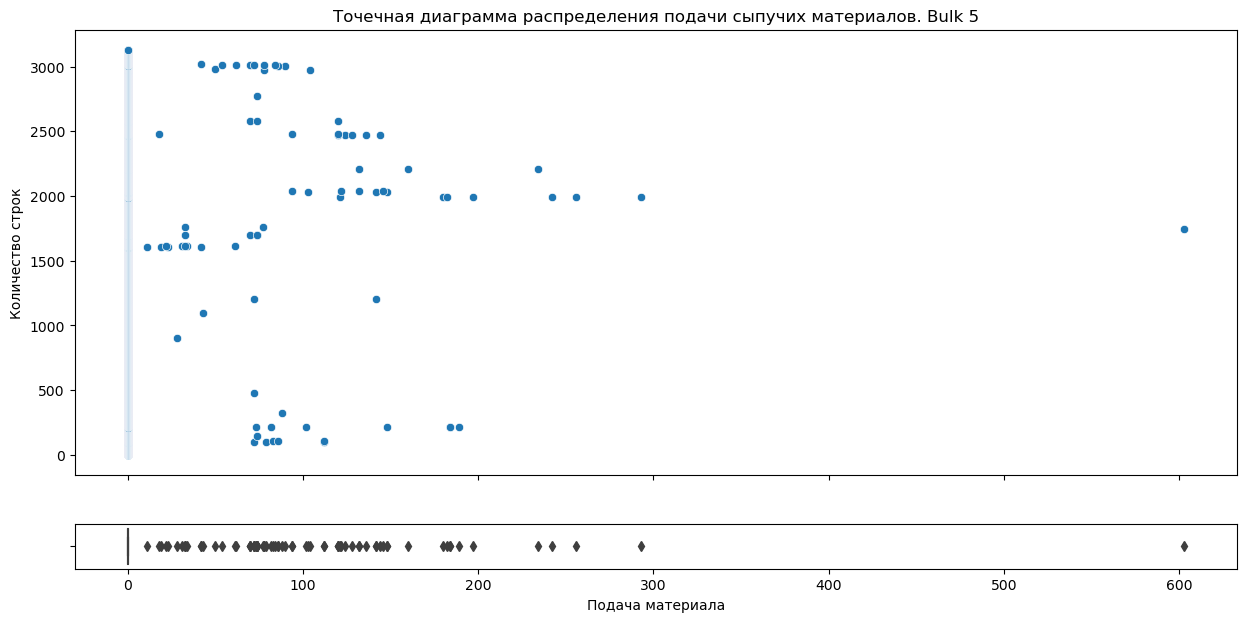

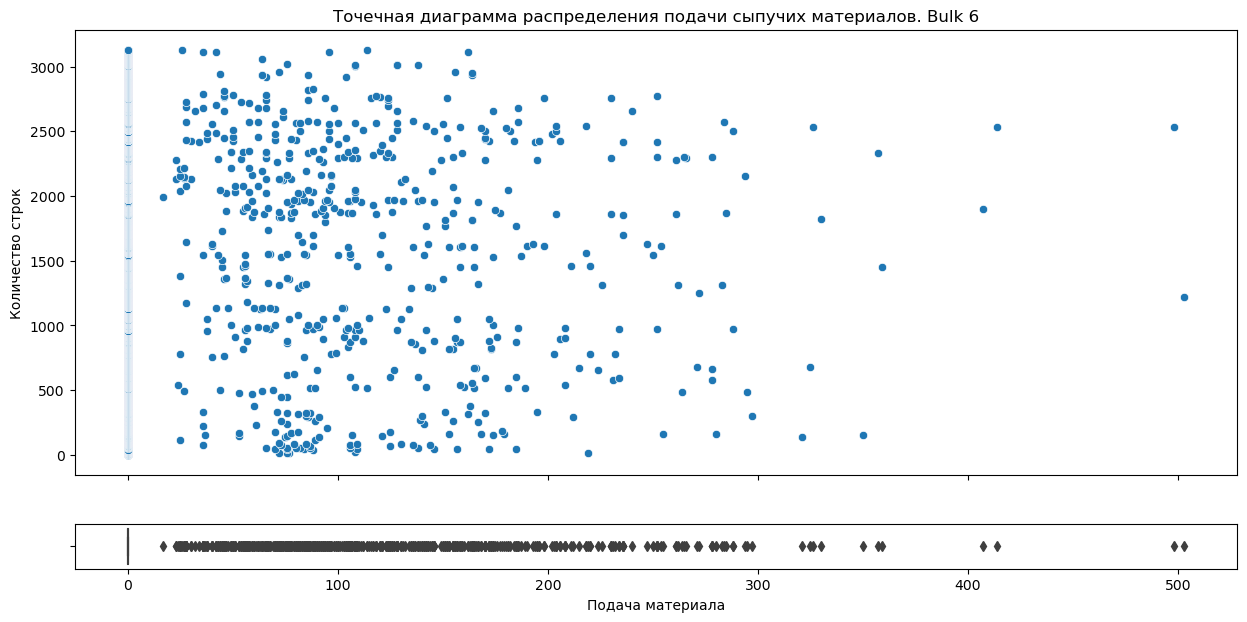

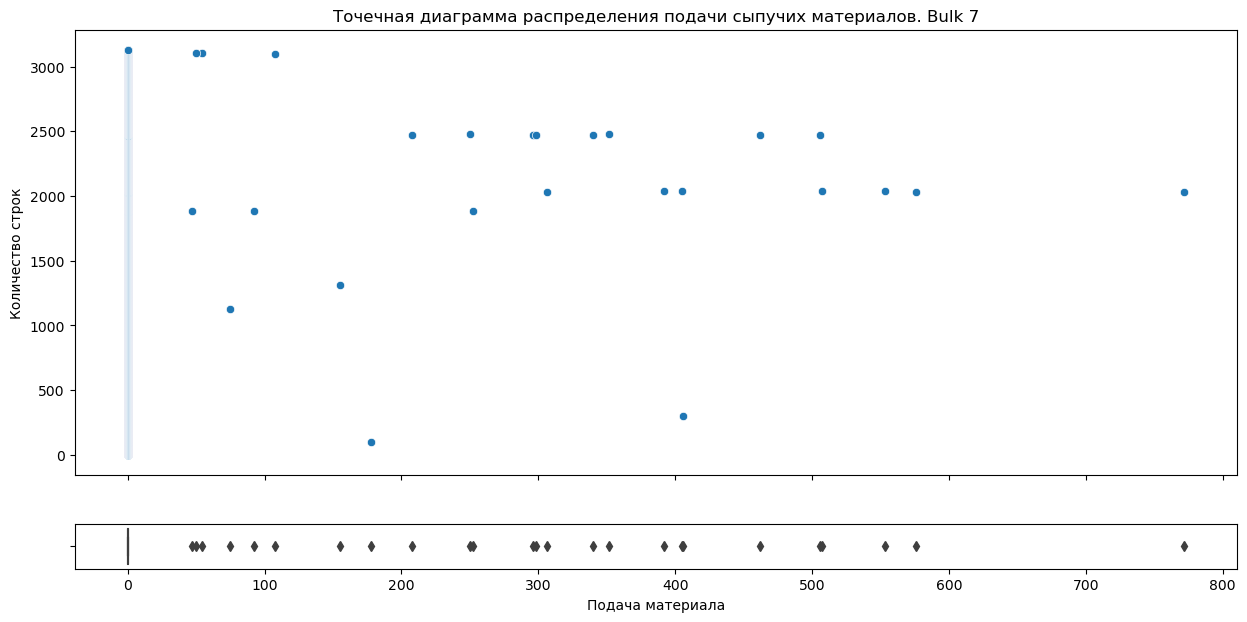

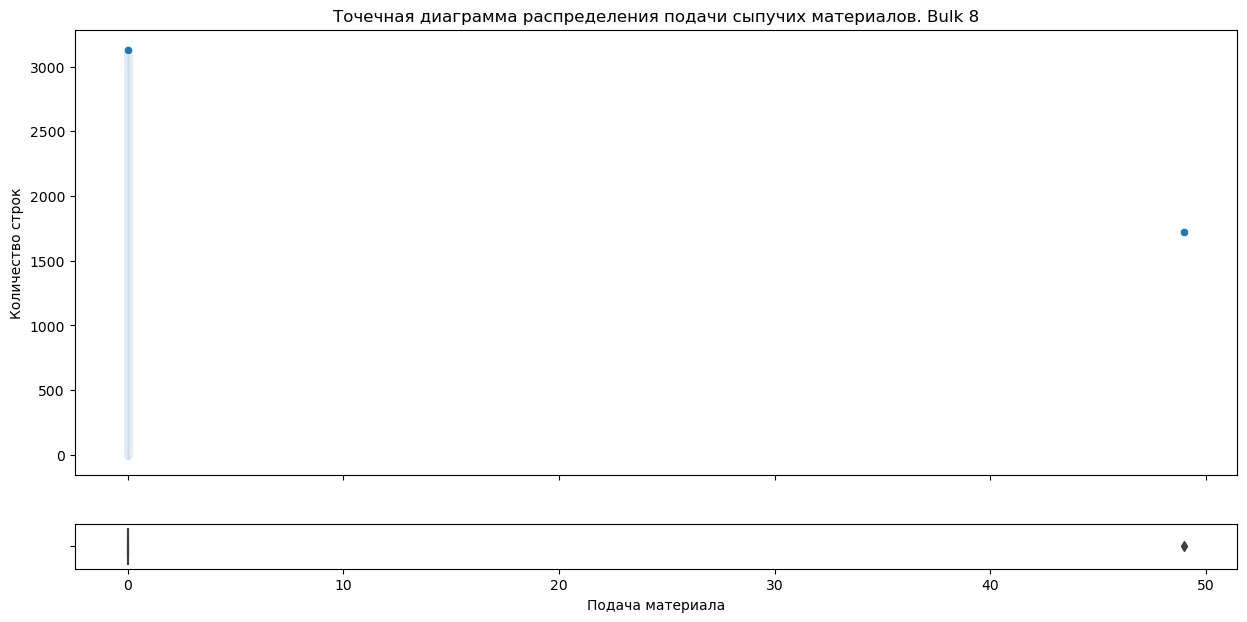

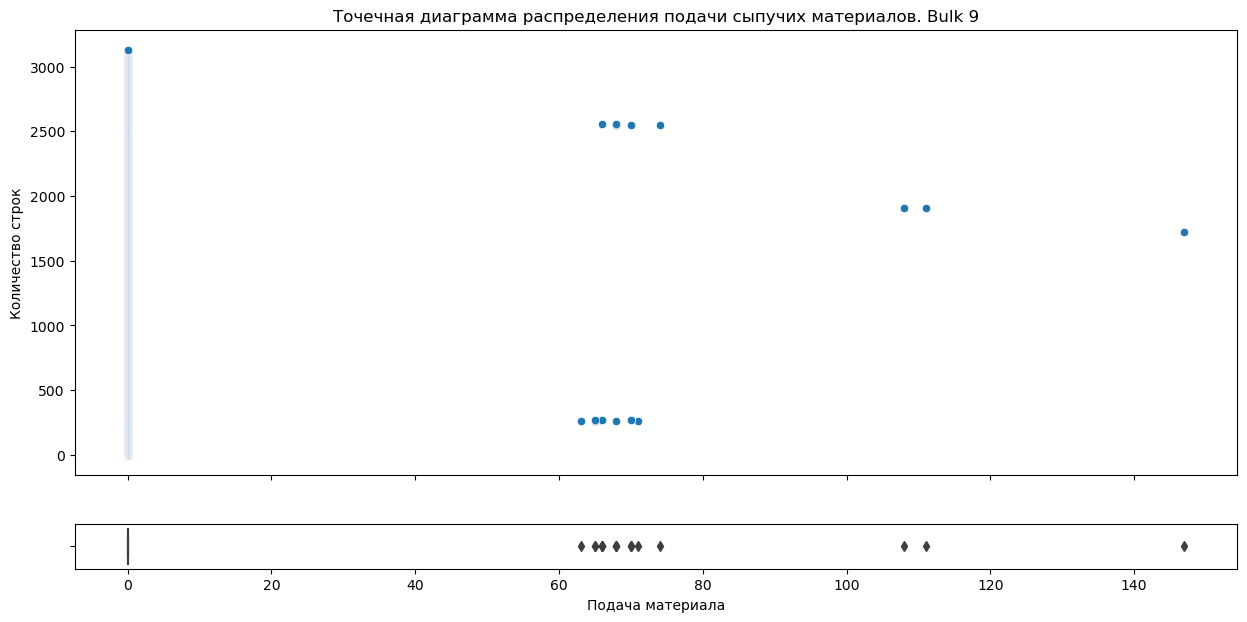

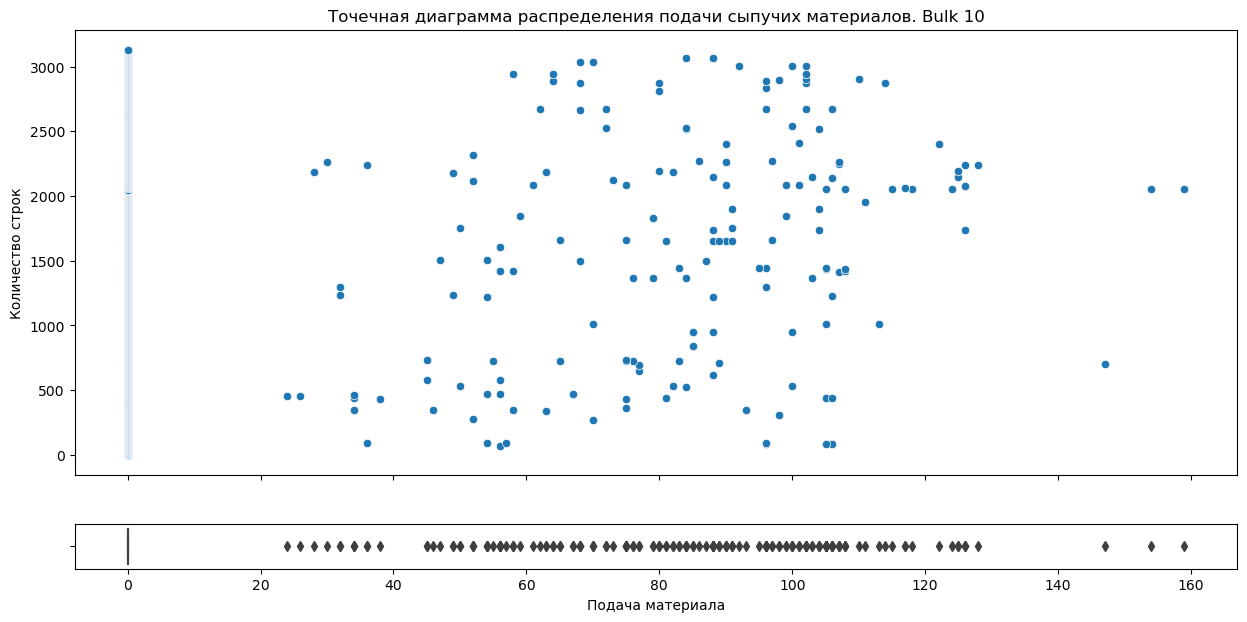

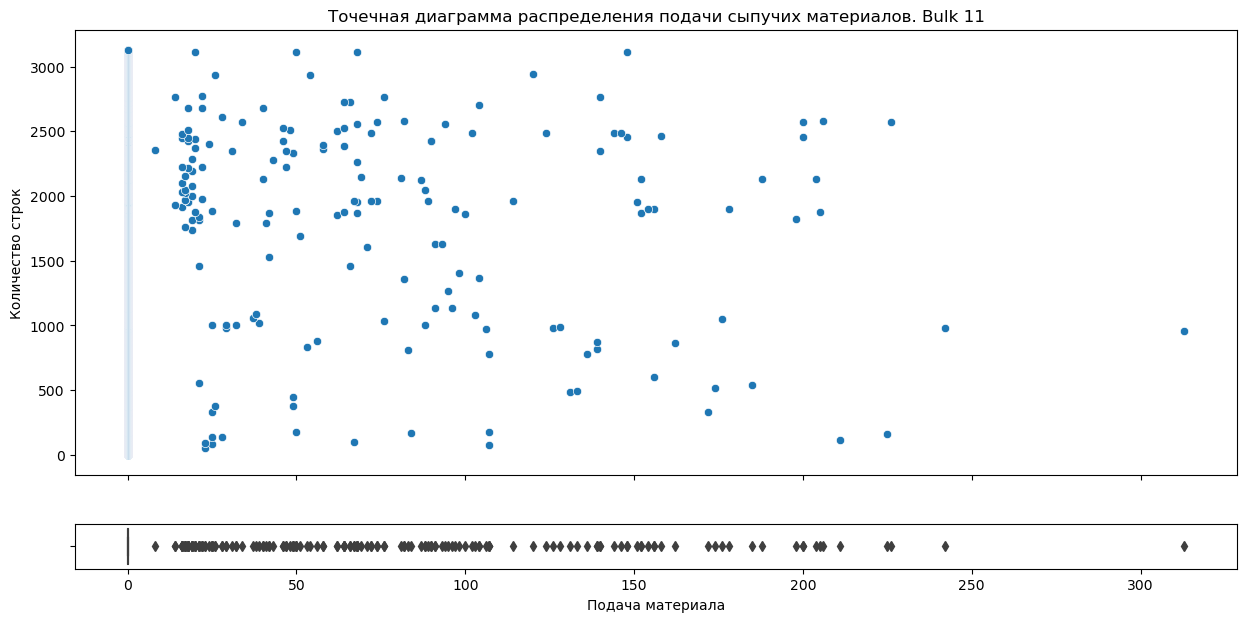

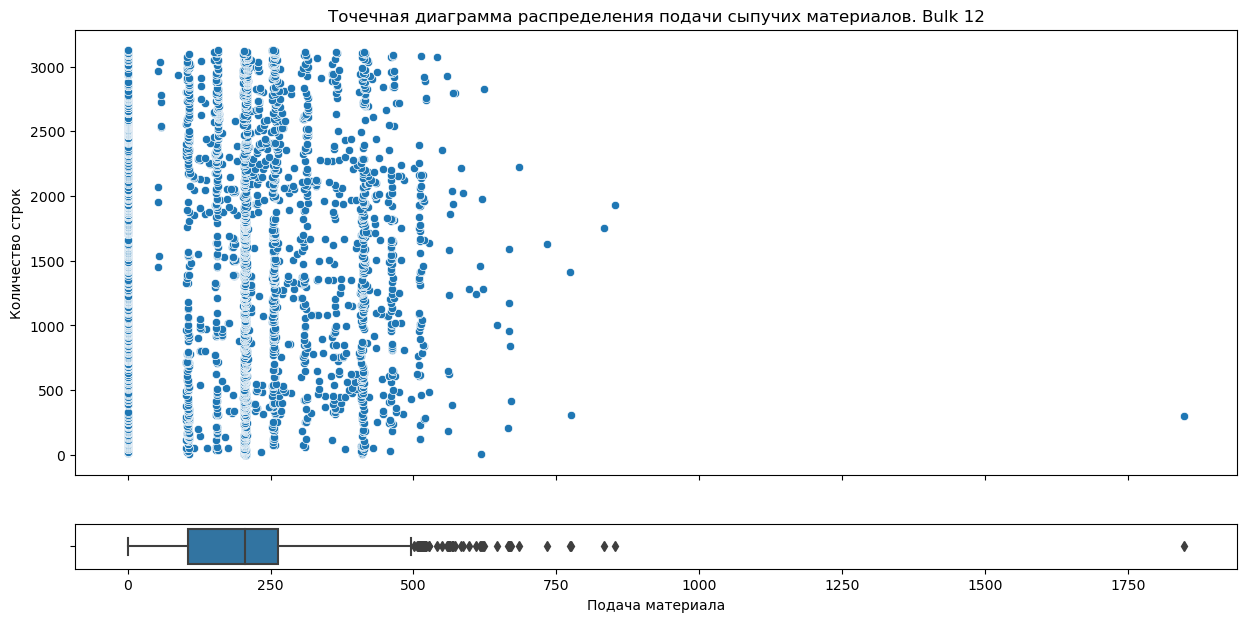

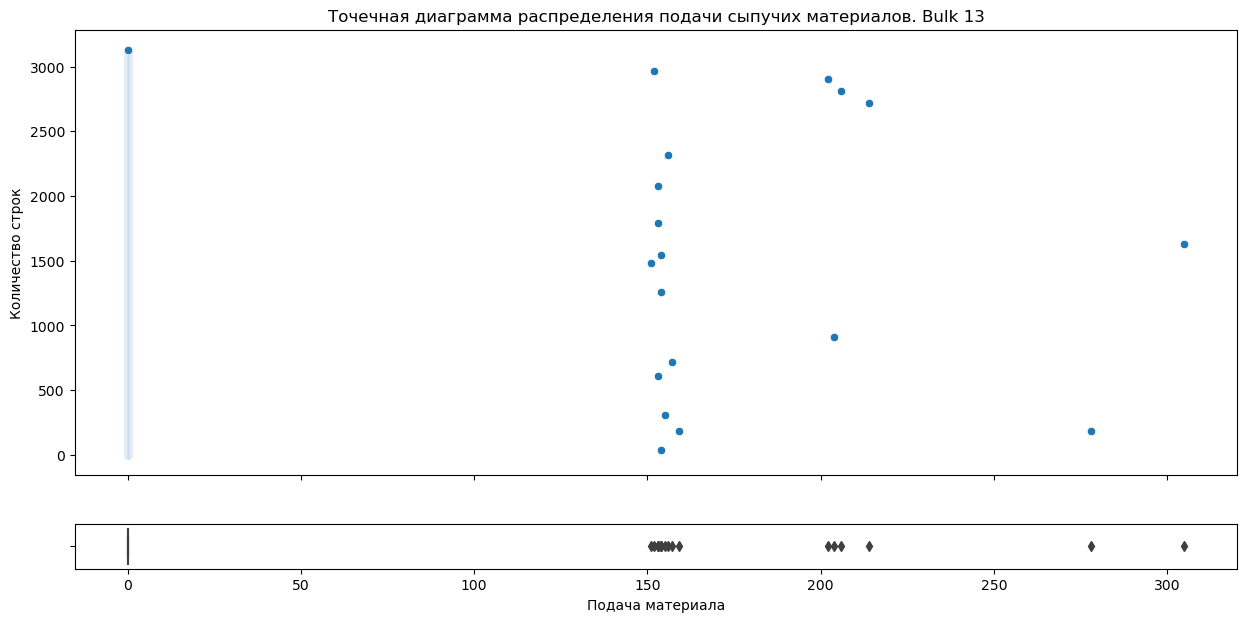

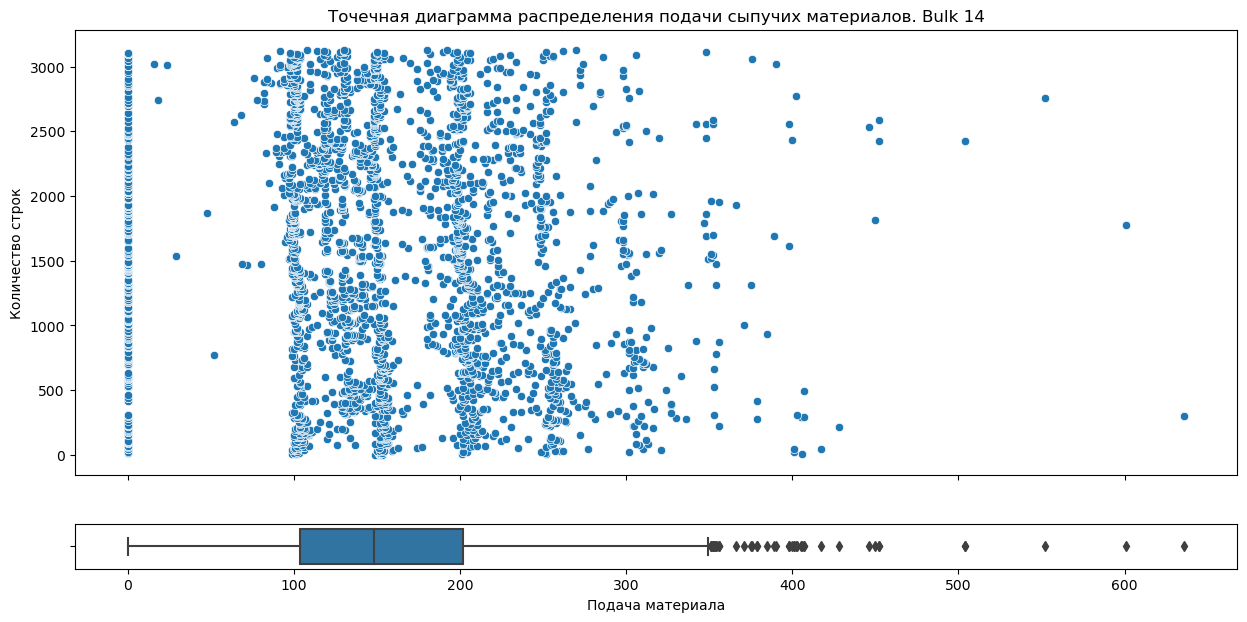

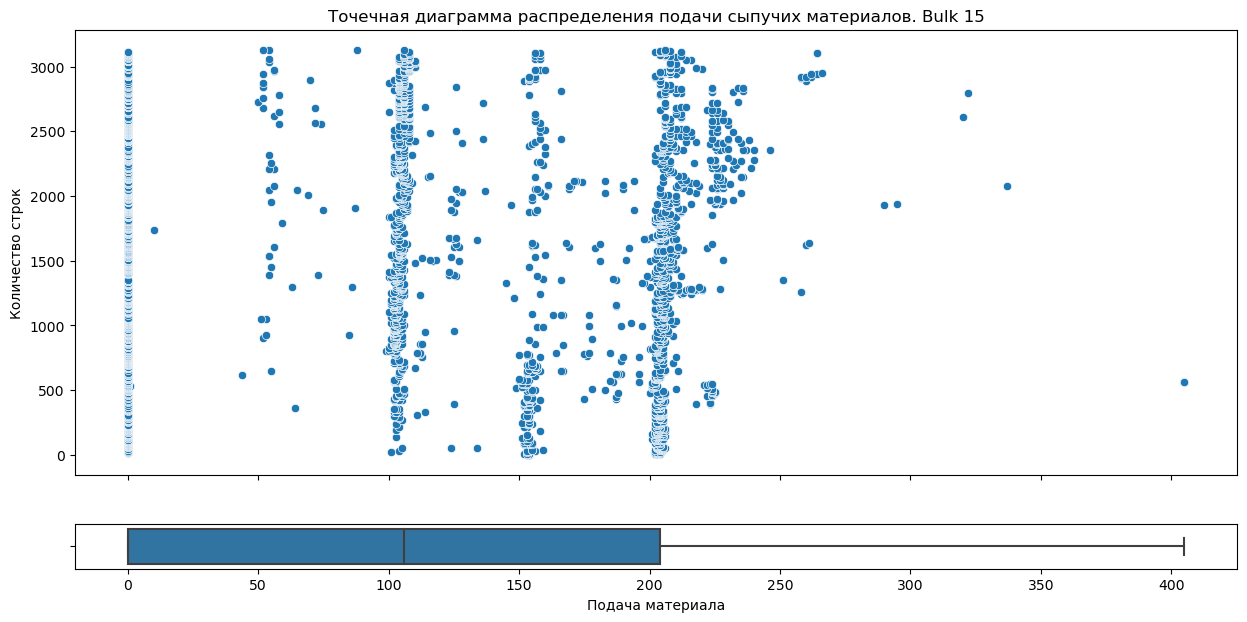

In [39]:
bulks = data_bulk_new.columns.to_list()[1:]

for bulk in bulks:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7), 
                                          sharex=True,
                                          gridspec_kw=dict(height_ratios=[10,1]))
    
    bulk_hist = sns.scatterplot(data=data_bulk_new, x=bulk, y=range(len(data_bulk_new)), ax=axs_hist)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Точечная диаграмма распределения подачи сыпучих материалов. ' + bulk)
    
    bulk_box = sns.boxplot(data=data_bulk_new, x=bulk, ax=axs_box)
    bulk_box.set_xlabel('Подача материала')

In [40]:
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


In [41]:
count_above_threshold = (data_bulk_new > 0).sum()
result_df = pd.DataFrame({'Название столбца': count_above_threshold.index, 'Количество значений > 0': count_above_threshold.values})
result_df = result_df.sort_values(by='Количество значений > 0', ascending=False)
print(result_df)

   Название столбца  Количество значений > 0
0               key                     3129
14          Bulk 14                     2806
12          Bulk 12                     2450
15          Bulk 15                     2248
3            Bulk 3                     1298
4            Bulk 4                     1014
6            Bulk 6                      576
1            Bulk 1                      252
11          Bulk 11                      177
10          Bulk 10                      176
5            Bulk 5                       77
7            Bulk 7                       25
2            Bulk 2                       22
9            Bulk 9                       19
13          Bulk 13                       18
8            Bulk 8                        1


Видно, что сыпучие материалы добавляются в разных объемах, в среднем больше всего добавляют Bulk 12, 14, 15, одновременно, эти столбцы имеют больше всего уникальных значений.  Наименьшие средние значения у Bulk 8, 9, 13, также, эти столбцы имеют меньше всего уникальных значений.

<b>Данные о подаче сыпучих материалов (время)</b>

data_bulk_time_new содержит информацию о времени подачи материалов, она нам далее не потребуется.

<b>Данные о продувке сплава газом</b>

array([[<AxesSubplot:title={'center':'Газ 1'}>]], dtype=object)

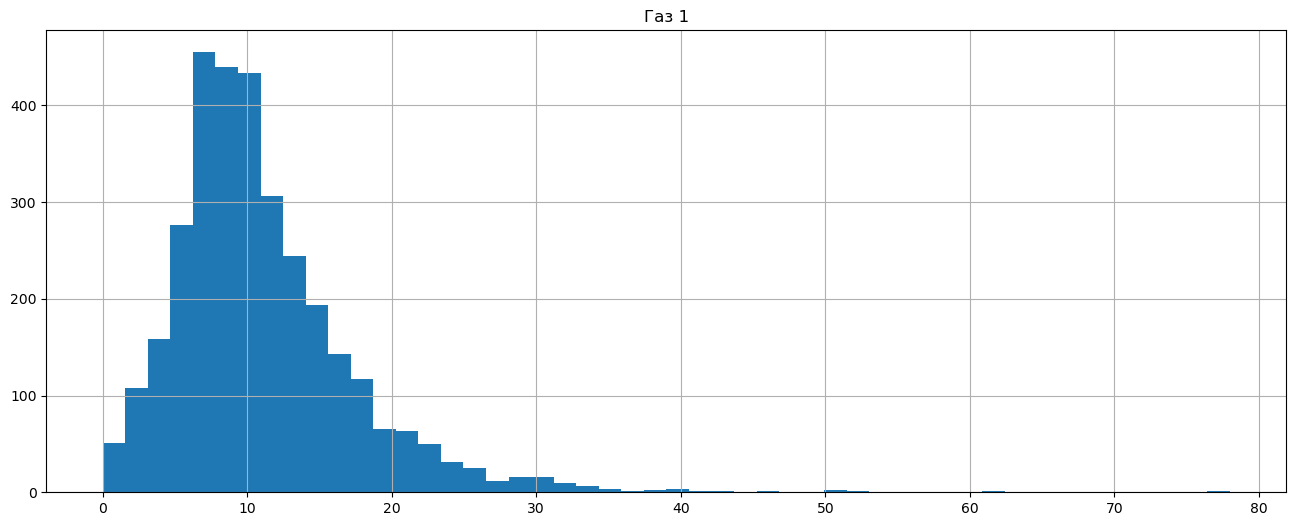

In [42]:
data_gas_new.drop('key',axis=1).hist(figsize=(16, 6), bins=50)

В данном датасете имеются выбросы. Можно предположить, что они появляются в момент подачи добавок (согласно технологическому процессу). Т.к. это фактические данные от заказчика - не будем их изменять.

<b>Результаты измерения температуры</b>

array([[<AxesSubplot:title={'center':'Температура'}>]], dtype=object)

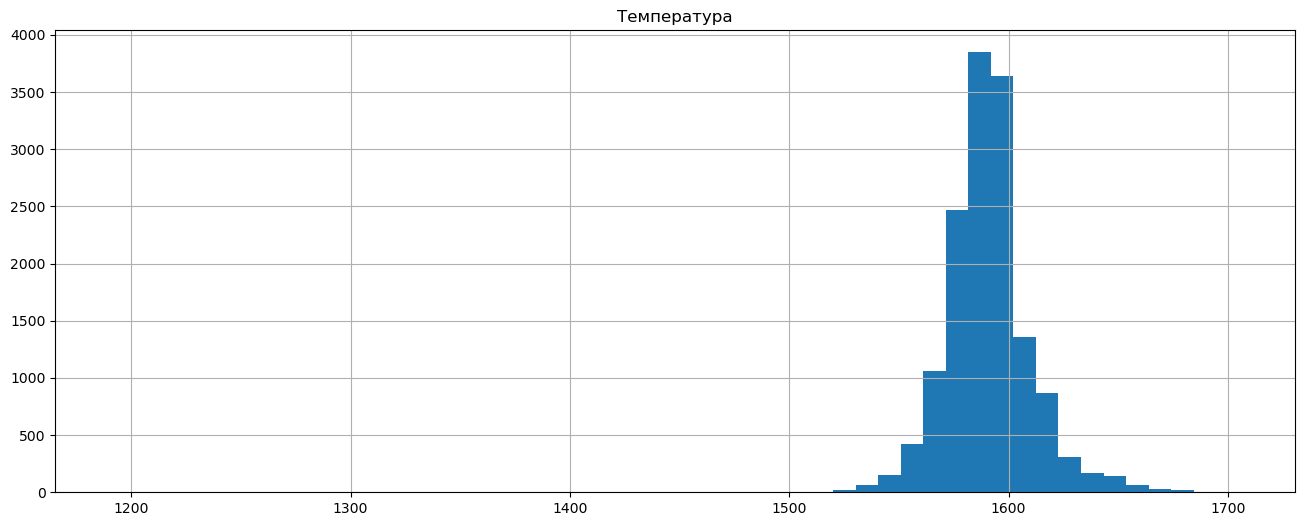

In [43]:
data_temp_new.drop('key',axis=1).hist(figsize=(16, 6), bins=50)

Температура плавления стали больше 1500 градусов. Проверим, есть ли значения, не удовлетворяющие этому условию.

In [44]:
data_temp_new.query('Температура < 1500')

,key,Время замера,Температура
4883,867,2019-06-06 08:03:39,1191.0
6784,1214,2019-06-18 08:01:03,1208.0
9050,1619,2019-07-03 02:34:41,1218.0
11495,2052,2019-07-25 08:49:15,1227.0
14283,2561,2019-08-12 18:49:29,1204.0


In [45]:
keys_temp = data_temp_new.query('Температура < 1500')['key'].tolist()
print(keys_temp)

[867, 1214, 1619, 2052, 2561]


In [46]:
data_temp_new=data_temp_new.query('key not in @keys_temp')

Данные, где температура менее 1500 градусов удалены.

Найдем пропущенные значения.

In [47]:
data_temp_new['Температура'].isna().sum()

3422

In [48]:
data_temp_new_gr = data_temp_new.groupby('key')
data_temp_new_filt = data_temp_new_gr.filter(lambda x: x['Температура'].isna().any())
temp_0 = data_temp_new_filt['key'].unique()
print(len(temp_0))

738


In [49]:
data_temp_new=data_temp_new.query('key not in @temp_0')

In [50]:
data_temp_new['Температура'].isna().sum()

0

Пропущенные значения удалены.

В данном датасете присутствуют измерения температуры в различные промежутки времени для каждой партии. Сохраним данные температуры только для первого и последнего измерения для каждой партии.

In [51]:
#first_temp = temp1 = data_temp_new.groupby('key')['Температура'].first().reset_index()

In [52]:
temp1 = data_temp_new.groupby('key')['Температура'].first().reset_index()
temp2 = data_temp_new.groupby('key')['Температура'].last().reset_index()
data_temp_new = data_temp_new.merge(temp1.rename(columns={'Температура':'Температура нач'}), how='left', on='key')
data_temp_new = data_temp_new.merge(temp2.rename(columns={'Температура':'Температура кон'}), how='left', on='key')
data_temp_new.head()

,key,Время замера,Температура,Температура нач,Температура кон
0,1,2019-05-03 11:02:04,1571.0,1571.0,1613.0
1,1,2019-05-03 11:07:18,1604.0,1571.0,1613.0
2,1,2019-05-03 11:11:34,1618.0,1571.0,1613.0
3,1,2019-05-03 11:18:04,1601.0,1571.0,1613.0
4,1,2019-05-03 11:25:59,1606.0,1571.0,1613.0


Удалим дубликаты.

Добавим доп признак - промежуток времени между первым и последним измерением температуры, мин.

In [53]:
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])
delta_time = ((data_temp_new.groupby('key')['Время замера'].last() - data_temp_new.groupby('key')['Время замера'].first()).dt.total_seconds()/60).astype(float)

Удалим лишние столбцы и дубликаты.

In [54]:
data_temp_new = data_temp_new.drop(['Время замера', 'Температура'], axis=1)
data_temp_new = data_temp_new.drop_duplicates(subset='key')

In [55]:
delta_time_1 = delta_time.to_dict()
data_temp_new['Длительность измерения'] = data_temp_new['key'].map(delta_time_1)

In [56]:
data_temp_new.head()

,key,Температура нач,Температура кон,Длительность измерения
0,1,1571.0,1613.0,28.566667
6,2,1581.0,1602.0,21.083333
11,3,1596.0,1599.0,29.216667
17,4,1601.0,1625.0,20.333333
22,5,1576.0,1602.0,25.600000


<b>Данные о проволочных материалах (объём)</b>

Пропуски означают, что проволочные материалы не добавлялись. Заменим их на 0.

In [57]:
data_wire_new=data_wire_new.fillna(0)

In [58]:
data_wire_new.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


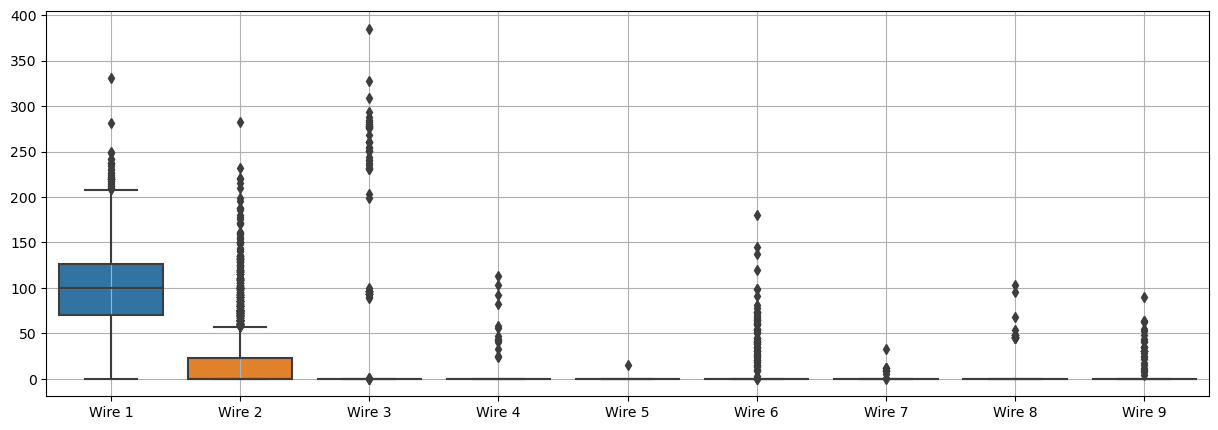

In [59]:
plt.figure(figsize=(15,5))
sns.boxplot(data=data_wire_new.drop('key',axis=1))
plt.grid();

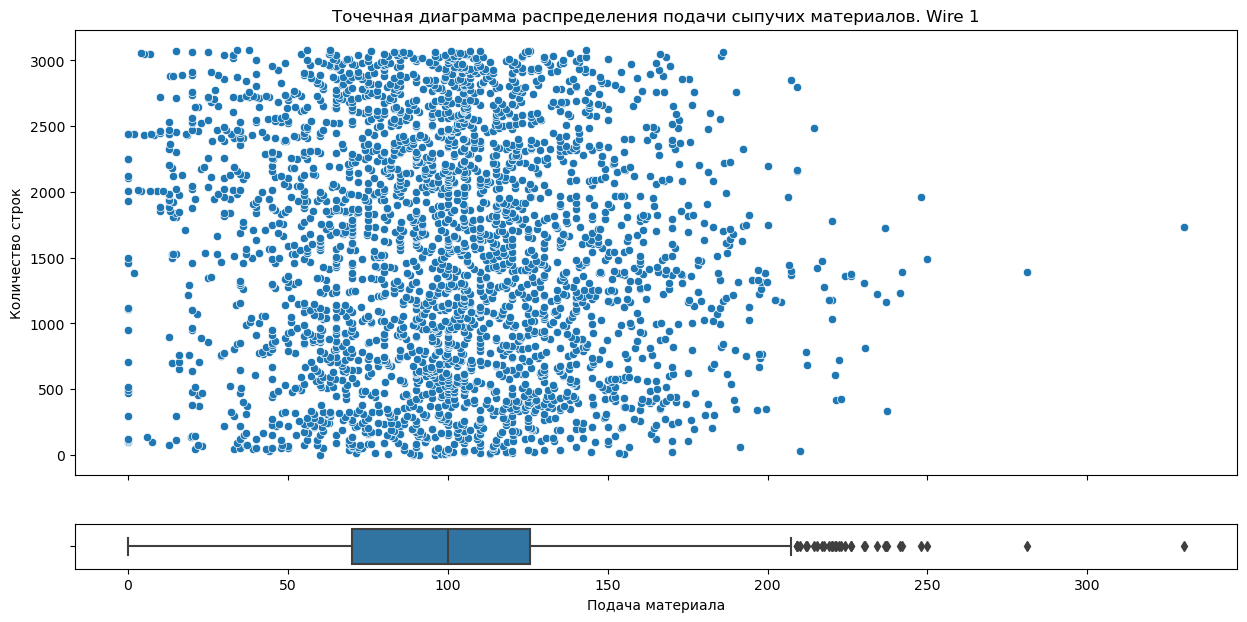

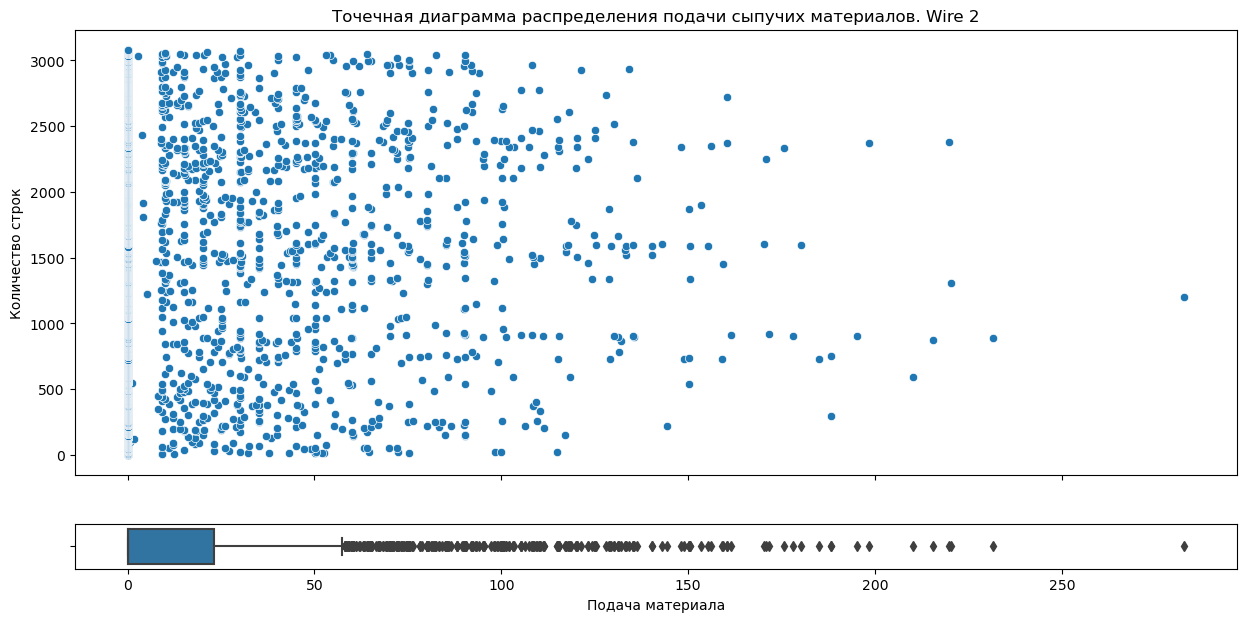

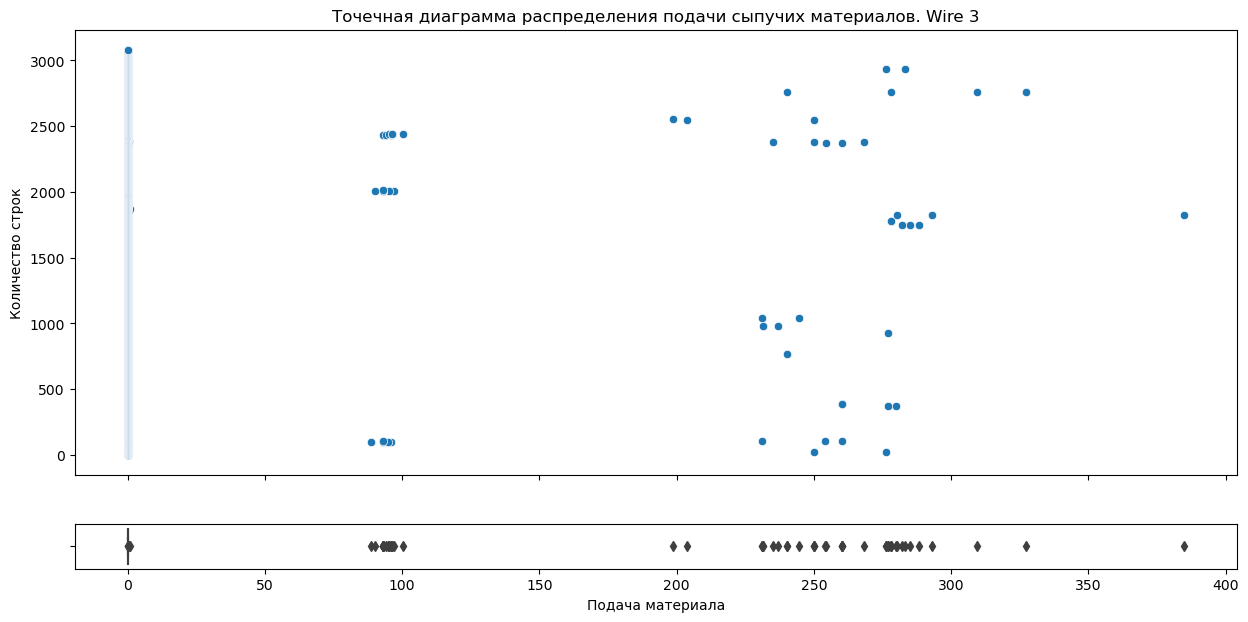

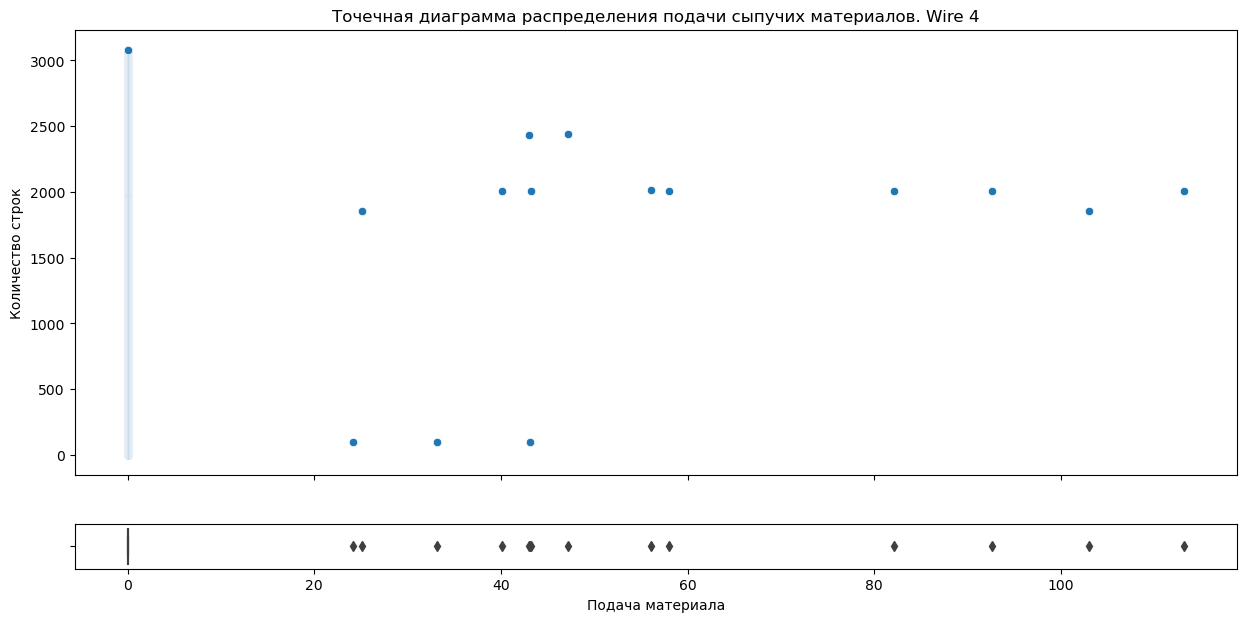

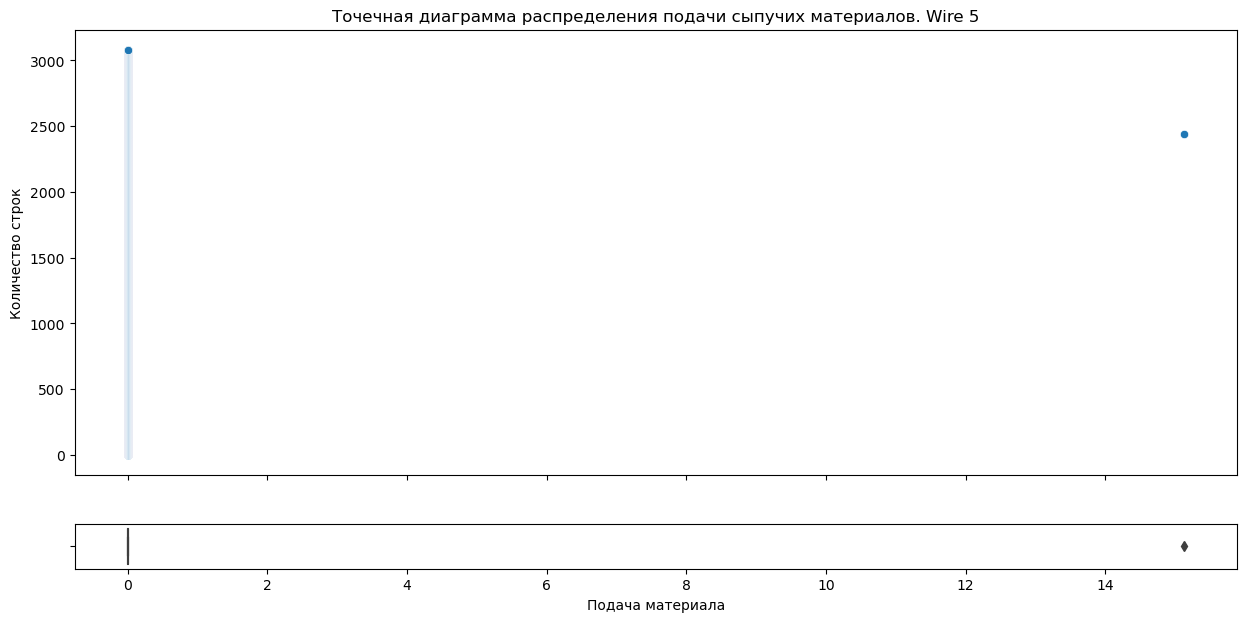

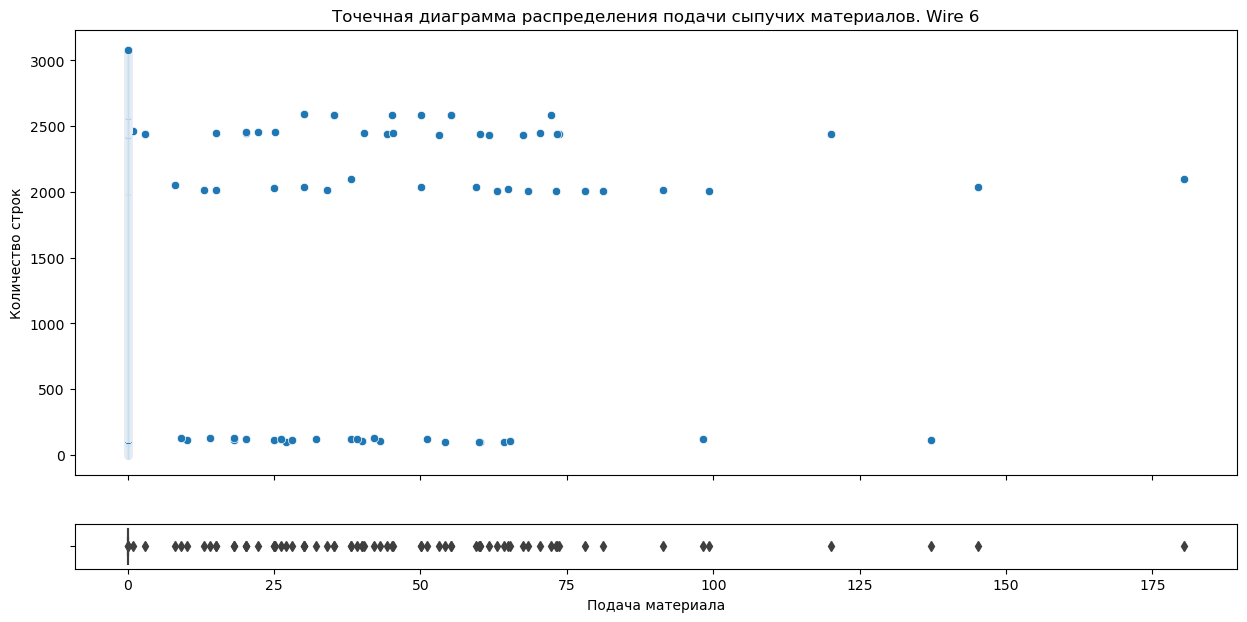

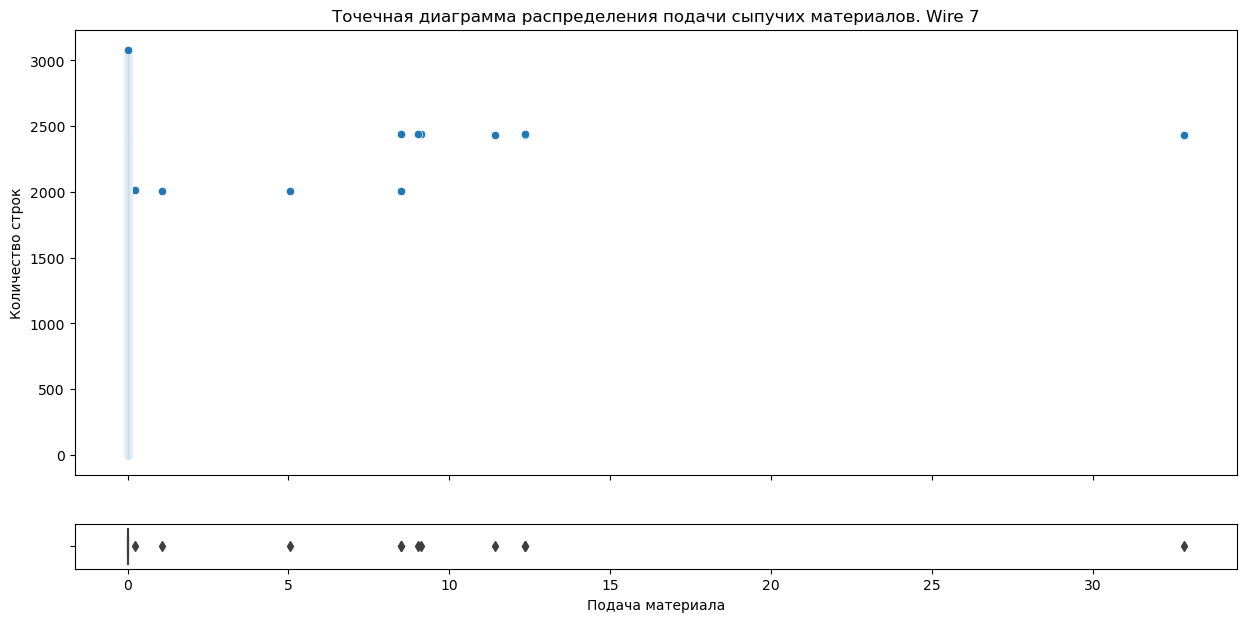

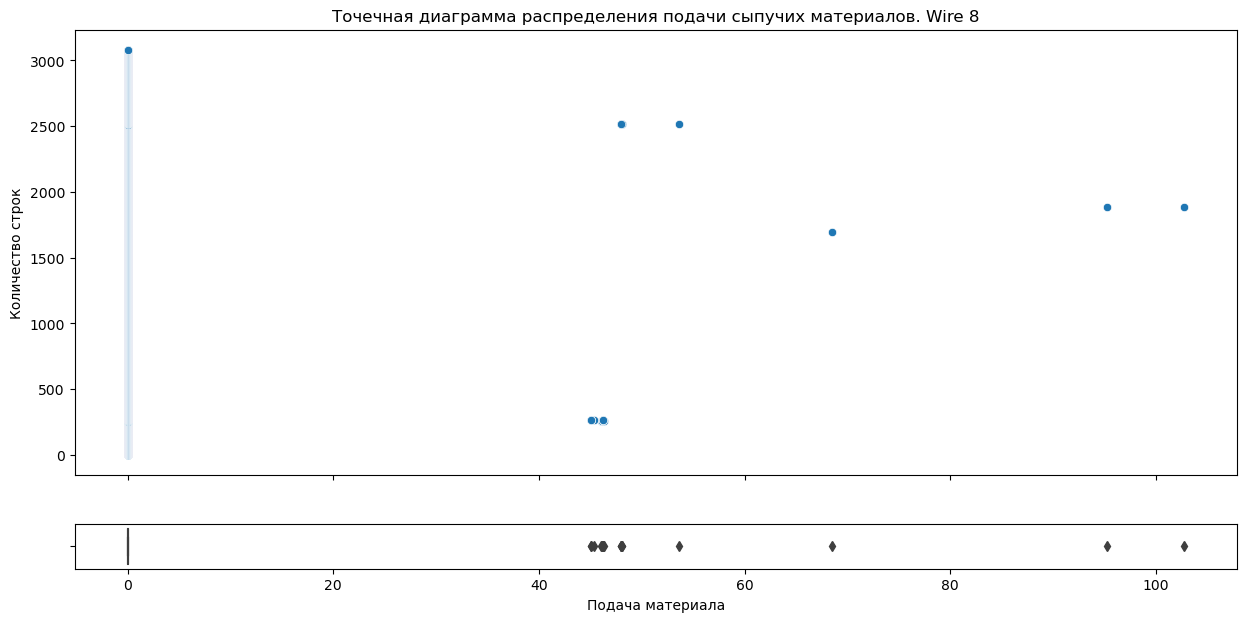

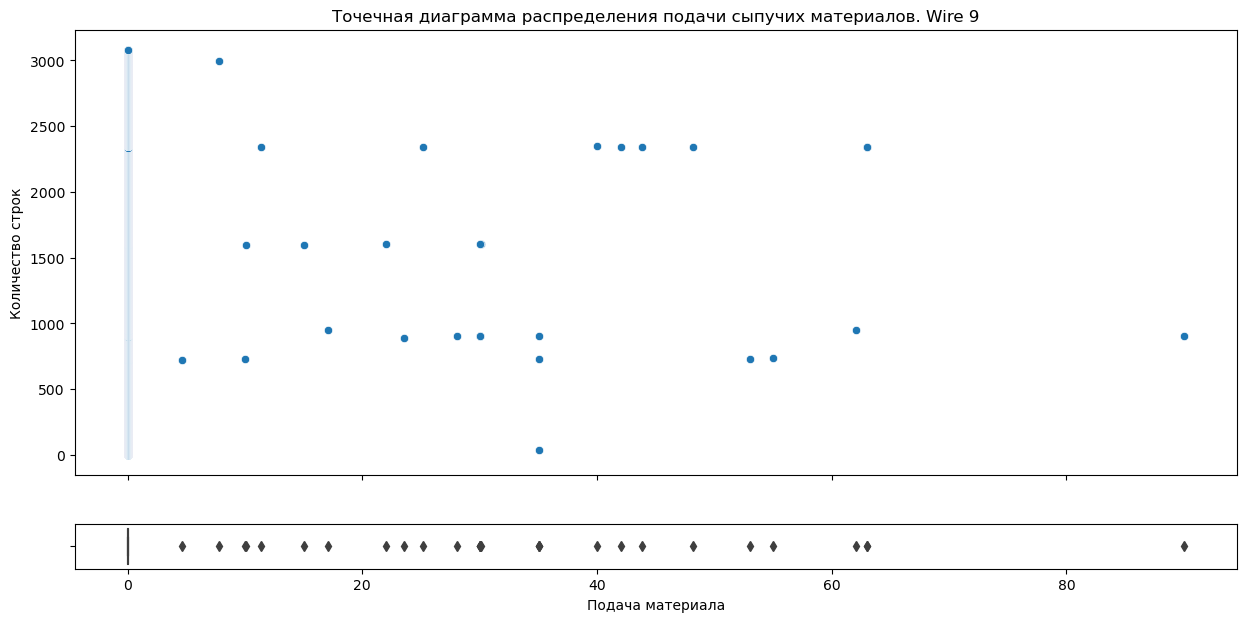

In [60]:
wires = data_wire_new.columns.to_list()[1:]

for wire in wires:
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(15, 7), 
                                          sharex=True,
                                          gridspec_kw=dict(height_ratios=[10,1]))
    
    bulk_hist = sns.scatterplot(data=data_wire_new, x=wire, y=range(len(data_wire_new)), ax=axs_hist)
    bulk_hist.set_ylabel('Количество строк')
    bulk_hist.set_title('Точечная диаграмма распределения подачи сыпучих материалов. ' + wire)
    
    bulk_box = sns.boxplot(data=data_wire_new, x=wire, ax=axs_box)
    bulk_box.set_xlabel('Подача материала')

In [61]:
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,1623.426485,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,932.996726,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,823.000000,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1619.000000,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2434.000000,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


In [62]:
count_above_wire = (data_wire_new > 0).sum()
result_df = pd.DataFrame({'Название столбца': count_above_wire.index, 'Количество значений > 0': count_above_wire.values})
result_df = result_df.sort_values(by='Количество значений > 0', ascending=False)
print(result_df)

  Название столбца  Количество значений > 0
0              key                     3081
1           Wire 1                     3055
2           Wire 2                     1079
6           Wire 6                       73
3           Wire 3                       63
9           Wire 9                       29
8           Wire 8                       19
4           Wire 4                       14
7           Wire 7                       11
5           Wire 5                        1


Видно, что проволочные материалы добавляются в разных объемах, в среднем больше всего добавляют Wire1 (значительно больше чем все остальные вместе взятые). Меньше всего wire4.
Чаще всего добавляют Wire1, реже всего Wire 5.

<b>Данные о проволочных материалах (время)</b>

data_wire_time_new содержит информацию о времени подачи материалов, она нам далее не потребуется.

<b>Создадим единую таблицу</b>

In [63]:
data1 = pd.merge(data_arc, data_bulk_new, how='inner', on='key')
data2 = pd.merge(data1, data_gas_new, how='inner', on='key')
data3 = pd.merge(data2, data_temp_new, how='inner', on='key')
data = pd.merge(data3, data_wire_new, how='inner', on='key')
data.rename(columns={col:col.lower() for col in data.columns}, inplace=True) 

In [64]:
data.rename(columns={col:col.lower() for col in data.columns}, inplace=True) #убрали заглавные буквы в назв столбцов
data.columns = data.columns.str.replace(' ', '_') #заменили пробелы нижним подчеркиванием

In [65]:
data = data.drop('key', axis=1)

In [66]:
data.head()

,полная_мощность_сум,общее_время_нагрева,электроэнергия,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,...,длительность_измерения,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,3.718736,1098.0,4083.171936,0.0,0.0,0.0,43.0,0.0,0.0,0.0,...,28.566667,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.588349,811.0,2099.150800,0.0,0.0,0.0,73.0,0.0,0.0,0.0,...,21.083333,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.019223,655.0,3287.591368,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,29.216667,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.400038,741.0,2519.428170,0.0,0.0,0.0,81.0,0.0,0.0,0.0,...,20.333333,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.816980,869.0,2447.955323,0.0,0.0,0.0,78.0,0.0,0.0,0.0,...,25.600000,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   полная_мощность_сум     2325 non-null   float64
 1   общее_время_нагрева     2325 non-null   float64
 2   электроэнергия          2325 non-null   float64
 3   bulk_1                  2325 non-null   float64
 4   bulk_2                  2325 non-null   float64
 5   bulk_3                  2325 non-null   float64
 6   bulk_4                  2325 non-null   float64
 7   bulk_5                  2325 non-null   float64
 8   bulk_6                  2325 non-null   float64
 9   bulk_7                  2325 non-null   float64
 10  bulk_8                  2325 non-null   float64
 11  bulk_9                  2325 non-null   float64
 12  bulk_10                 2325 non-null   float64
 13  bulk_11                 2325 non-null   float64
 14  bulk_12                 2325 non-null   

In [68]:
pd.set_option('display.max_columns', None)
filtered_df = data[data['газ_1'] > 70]

print(filtered_df)

     полная_мощность_сум  общее_время_нагрева  электроэнергия  bulk_1  bulk_2  \
289            11.075555               2658.0    29438.824694   185.0     0.0   

     bulk_3  bulk_4  bulk_5  bulk_6  bulk_7  bulk_8  bulk_9  bulk_10  bulk_11  \
289   101.0    58.0     0.0     0.0   406.0     0.0     0.0      0.0      0.0   

     bulk_12  bulk_13  bulk_14  bulk_15     газ_1  температура_нач  \
289   1849.0      0.0    636.0      0.0  77.99504           1619.0   

     температура_кон  длительность_измерения  wire_1     wire_2  wire_3  \
289           1616.0                  116.85     0.0  188.22855     0.0   

     wire_4  wire_5  wire_6  wire_7  wire_8  wire_9  
289     0.0     0.0     0.0     0.0     0.0     0.0  


<font color='steelblue'>Стоит отметить,что выброс газа совпадает с выбросом bulk 12</font>

Построим тепловую карту по корреляционной матрице для анализа на мультиколлинеарность.

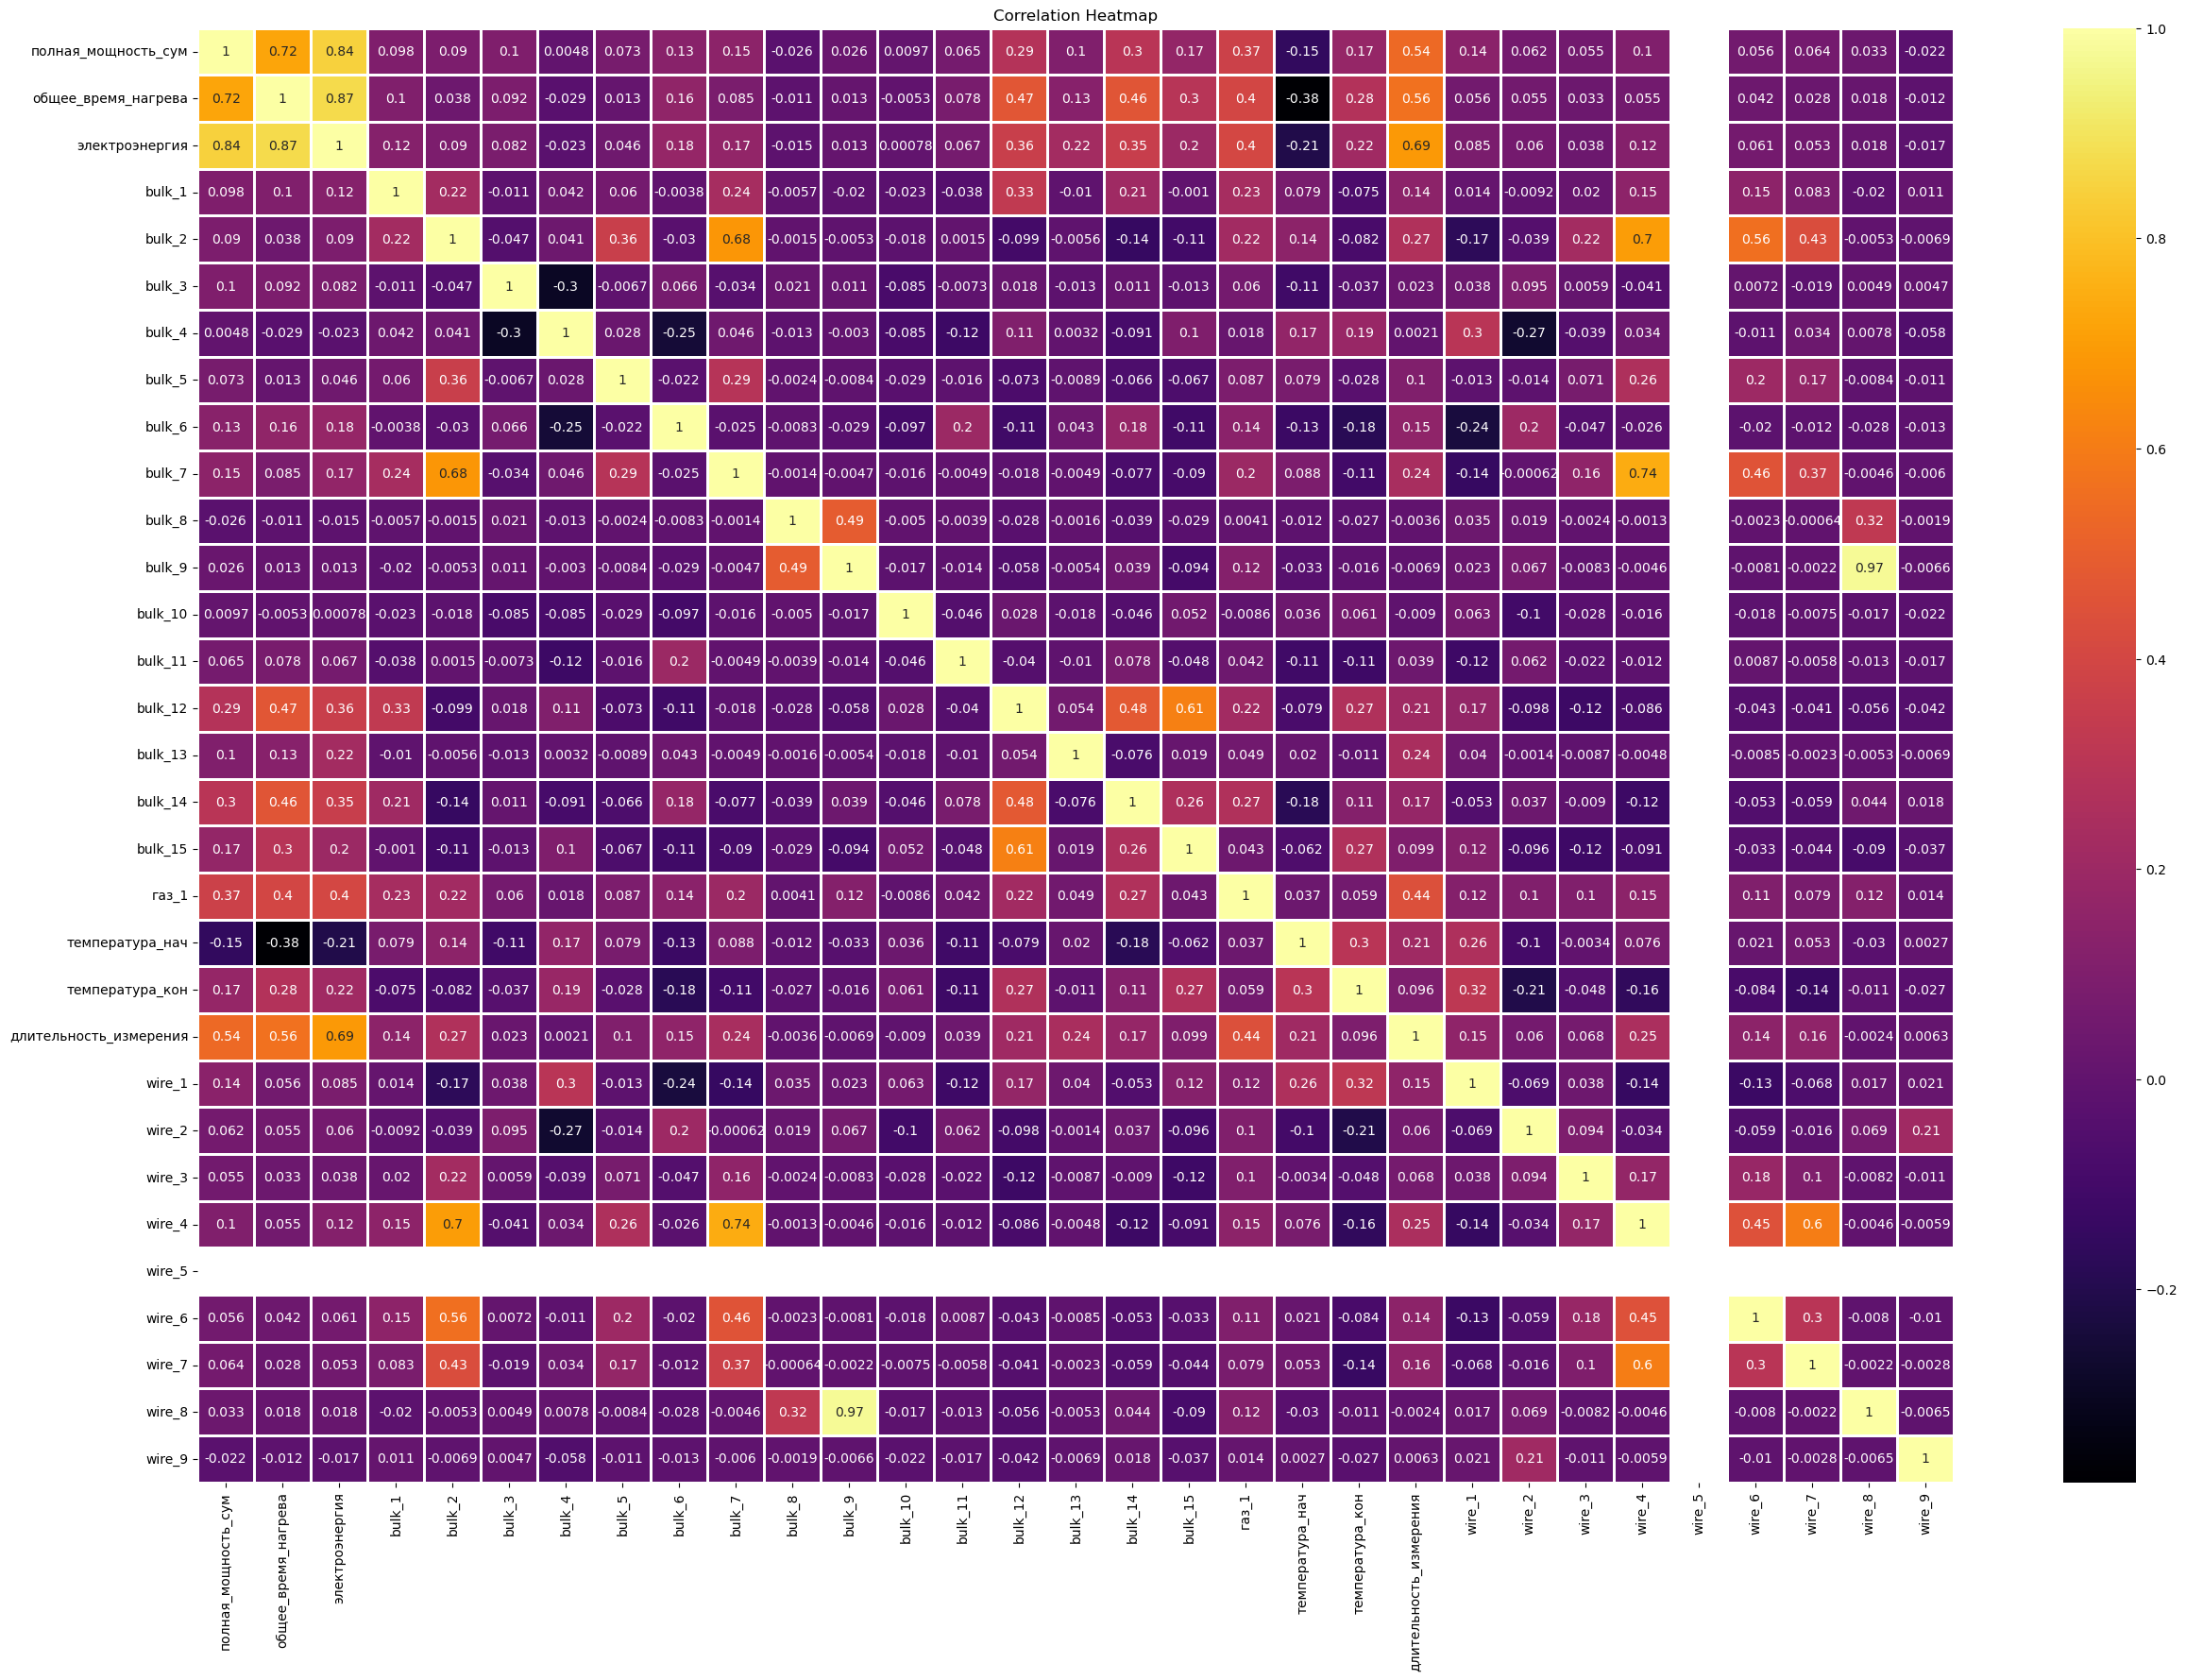

In [69]:
correlation_matrix = data.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno', linewidths=2)
plt.title('Correlation Heatmap')
plt.show()

Согласно тепловой карте у wire_5 отсутствует корреляция с другими признаками.
у bulk_9 и wire_8 сильная корреляция между собой (вероятно данные элементы добавляются вместе) и практически отсутствует корреляция с целевым признаком 'температура_кон'.



<b>Вывод:</b> Была получена таблица из 31 столбца (30 - признаков, 1 - целевой) и 2325 строк.

- Удалены значения с температурой менее 1500 градусов.
- Созданы дополнительные признаки (длительность измерения, полная мощность, электроэнергия, общее время нагрева).
- Удалены столбцы, указывающие время добавления доп материалов.
- Обработаны пропуски.
- Проведен анализ на мультиколлинеарность.

Выбросы оставлены без изменения с учетом того, что они соответствуют реальному техпроцессу.

## Обучение моделей 

<b>Формирование целевого и обучающего признаков</b>

In [70]:
target = data.температура_кон
features = data.drop('температура_кон', axis = 1)

In [71]:
print(target.shape)

print(features.shape)

(2325,)
(2325, 30)


<b>Формирование тестовой и тренировочной выборки.</b>

In [72]:
f_train, f_test, t_train, t_test = train_test_split(features, target, test_size = 0.25,\
                                                    random_state = RANDOM_STATE)

In [73]:
print(f_train.shape)
print(f_test.shape)
print(t_train.shape)
print(t_test.shape)

(1743, 30)
(582, 30)
(1743,)
(582,)


<b>Линейная регрессия Ridge</b>

In [74]:
%%time

params = {
    'model__alpha': [x for x in np.logspace(-3, 2, num=100)],  
    'model__max_iter': [int(x) for x in np.linspace(5, 20, 5)]
}


pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('model', Ridge(random_state=RANDOM_STATE))
], verbose=False)


gcr = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=3,
    verbose=9,
    n_jobs=-1,
    scoring='neg_mean_absolute_error'
)


gcr.fit(f_train, t_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
Wall time: 5.16 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('model', Ridge(random_state=12923))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.001, 0.0011233240329780276,
                                          0.0012618568830660211,
                                          0.0014174741629268048,
                                          0.0015922827933410922,
                                          0.001788649529057435,
                                          0.002009233002565048,
                                          0.002257019719633919,
                                          0.0025353644939701114,
                                          0.002848035868435802,
                                          0.00...
                                          0.007220809018385464,
                                          0.008111308307896872,
                                          0.0

In [75]:
print('Лучший результат:', -gcr.best_score_)
print('Лучшие параметры:', gcr.best_params_)

Лучший результат: 6.0062159424473505
Лучшие параметры: {'model__alpha': 12.32846739442066, 'model__max_iter': 5}


<b>Случайный лес</b>

In [76]:
%%time

params = {
    'model__n_estimators': [int(x) for x in np.linspace(50, 300, 61)],
    'model__max_depth': [int(x) for x in np.linspace(3, 10, 8)],
    'model__min_samples_split': [int(x) for x in np.linspace(2, 10, 9)],
    'model__min_samples_leaf': [int(x) for x in np.linspace(1, 10, 10)],
    'model__criterion': ['mae'] 
}

pipeline = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, verbose=3))
], verbose=True)

gcrf = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=params,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=-1,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE
)

gcrf.fit(f_train, t_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
building tree 1 of 200
building tree 2 of 200


Criterion 'mae' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='absolute_error'` which is equivalent.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   21.5s finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              RandomForestRegressor(random_state=12923,
                                                                    verbose=3))],
                                      verbose=True),
                   n_jobs=-1,
                   param_distributions={'model__criterion': ['mae'],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_samples_leaf': [1, 2, 3, 4,
                                                                    5, 6, 7, 8,
                                                                    9, 10],
                                        'model__min_samples_split': [2, 3, 4, 5,
                                                            

In [77]:
print('Лучший результат:', -gcrf.best_score_)
print('Лучшие параметры:', gcrf.best_params_)

Лучший результат: 6.433724899598393
Лучшие параметры: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 8, 'model__max_depth': 7, 'model__criterion': 'mae'}


<b>CatBoostRegressor</b>

In [78]:
%%time

def objective(trial):
    
    params = {
        'iterations': trial.suggest_int('iterations', 100, 200),
        'depth': trial.suggest_int('depth', 1, 5),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'l2_leaf_reg': 0.8, 
        'random_seed': RANDOM_STATE,
        'loss_function': 'MAE',  
    }

    
    model = CatBoostRegressor(**params)

    
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    mae_scores = []

    for train_idx, valid_idx in kf.split(f_train):
        train_data, valid_data = f_train.iloc[train_idx], f_train.iloc[valid_idx]
        train_target, valid_target = t_train.iloc[train_idx], t_train.iloc[valid_idx]

        model.fit(train_data, train_target, eval_set=(valid_data, valid_target), verbose=False)
        preds = model.predict(valid_data)
        mae = mean_absolute_error(valid_target, preds)
        mae_scores.append(mae)

    
    return np.mean(mae_scores)


study = optuna.create_study(direction='minimize')


study.optimize(objective, n_trials=10)


best_params = study.best_params
best_mae = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший MAE:", best_mae)

[I 2023-11-12 22:59:21,711] A new study created in memory with name: no-name-cc9c234b-a551-4608-ac96-17765938e953
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-11-12 22:59:22,784] Trial 0 finished with value: 6.820482633077641 and parameters: {'iterations': 194, 'depth': 2, 'learning_rate': 0.020198555215208917}. Best is trial 0 with value: 6.820482633077641.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2023-11-12 22:59:23,533] Trial 1 finished with value: 7.022883696827049 and parameters: {'iterations': 129, 'depth': 3, 'learning_rate': 0.01399839354971777}. Best is trial 0 with value: 6.820482633077641.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.

Лучшие параметры: {'iterations': 192, 'depth': 4, 'learning_rate': 0.06216014091650912}
Лучший MAE: 6.030344261797938
Wall time: 8.22 s


<b>Анализ эффективности моделей.</b>

In [84]:
models = pd.DataFrame({'Линейная регрессия':[6.00], 'Случайный лес': [6.43], 'CatBoostRegressor': [6.03]}, index=['MAE'])
print(models)

     Линейная регрессия  Случайный лес  CatBoostRegressor
MAE                 6.0           6.43               6.03


Были опробованы модели Линейной регрессии, Случайного леса и CatBoost. Наибольшая точность у модели Линейной регрессии, MAE=6.0, при использованиия кросс-валидации.
Наименьшая скорость обучения у модели CatBoost, t=8 sec.

## Тестирование модели

<b>Оценка предсказаний CatBoost на тестовой выборке</b>

In [80]:
rscal = RobustScaler()
rscal.fit(f_train)


f_train1 = rscal.transform(f_train)
f_test1 = rscal.transform(f_test)


In [81]:
%%time

best_alpha = gcr.best_params_['model__alpha']
best_max_iter = gcr.best_params_['model__max_iter']


ridge_model = Ridge(alpha=best_alpha, max_iter=best_max_iter, random_state=RANDOM_STATE)

ridge_model.fit(f_train1, t_train)


t_pred = ridge_model.predict(f_test1)
mae = mean_absolute_error(t_test, t_pred)
print('МАЕ модели на тестовых данных:', round(mae, 2))

МАЕ модели на тестовых данных: 6.18
Wall time: 2.01 ms


Результат на тестовых данных не сильно отличается от результата на тренировачных. Это говорит об адекватности модели и отсутствии переобучения.

<b>Влияние признаков</b>

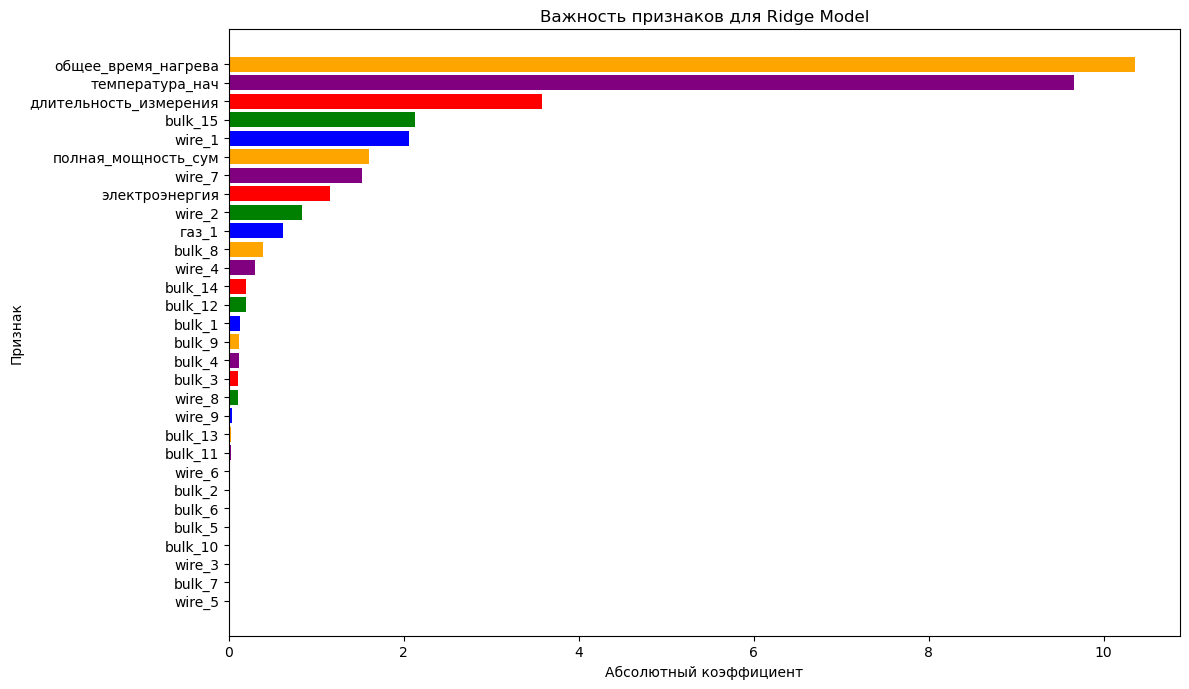

In [82]:
coefficients = ridge_model.coef_
feature_names = f_train.columns
coef_df = pd.DataFrame({'Признак': feature_names, 'Коэффициент': coefficients})
coef_df['Абсолютный коэффициент'] = np.abs(coef_df['Коэффициент'])
coef_df = coef_df.sort_values(by='Абсолютный коэффициент', ascending=True)
colors = ['blue', 'green', 'red', 'purple', 'orange']  
plt.figure(figsize=(12, 7))
plt.barh(coef_df['Признак'], coef_df['Абсолютный коэффициент'], color=colors)
plt.xlabel("Абсолютный коэффициент")
plt.ylabel("Признак")
plt.title("Важность признаков для Ridge Model")
plt.tight_layout()
plt.show()

Наиболее сильное влияние на модель оказывают такие признаки, как общее время нагрева и начальная температура. Из добавок наибольшее влияние оказывает bulk15 и wire_1 (можно предположить, что это связано с наибольшими их объемами). 

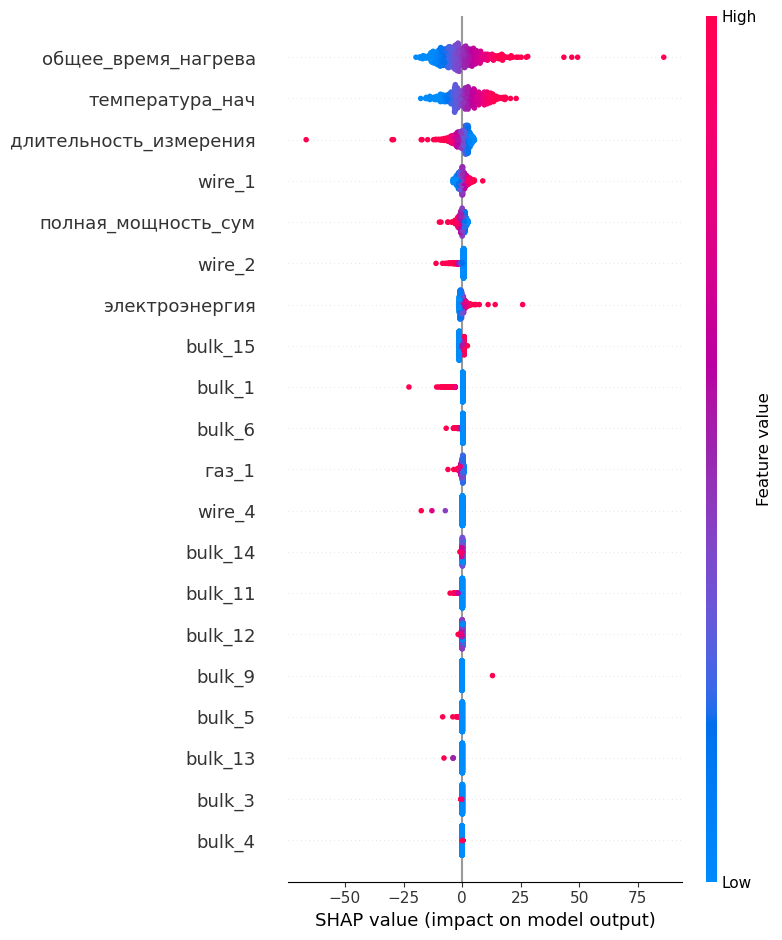

In [83]:
explainer = shap.Explainer(ridge_model, f_train1)
shap_values = explainer.shap_values(f_test1)
plt.figure(figsize=(160, 17))
shap.summary_plot(shap_values, f_test1, feature_names=f_test.columns, plot_type='dot')
plt.show()

Как и на графике ранее, на графике SHAP видно, что наиболее сильное влияние оказывают признаки время нагрева и начальная температура.

## Итоговый вывод

Данные были успешно загружены и открыты. Целевая переменная - значение температуры для каждого ковша на последнем этапе. В данных есть пропуски и выбросы.Данные с датой и временем не будут использоваться, однако другие столбцы можно использовать как доп признаки.

Была получена таблица из 31 столбца (30 - признаков, 1 - целевой) и 2325 строк.

- Удалены значения с температурой менее 1500 градусов.
- Созданы дополнительные признаки (длительность измерения, полная мощность, электроэнергия, общее время нагрева).
- Удалены столбцы, указывающие время добавления доп материалов.
- Обработаны пропуски.
- Проведен анализ на мультиколлинеарность.
Выбросы оставлены без изменения с учетом того, что они соответствуют реальному техпроцессу.

Были сформированы целевой и обучающие признаки, тестовая и тренировочная выборки.
Были опробованы модели Линейной регрессии, Случайного леса и CatBoost. Наибольшая точность у модели Линейной регрессии, MAE=6.0, при использованиия кросс-валидации. Наименьшая скорость обучения у модели CatBoost, t=8 sec.

МАЕ модели на тестовых данных: 6.18.
Результат на тестовых данных не сильно отличается от результата на тренировачных. Это говорит об адекватности модели и отсутствии переобучения.
Наиболее сильное влияние на модель оказывают такие признаки, как общее время нагрева и начальная температура. Из добавок наибольшее влияние оказывает bulk15 и wire_1 (можно предположить, что это связано с наибольшими их объемами). 
На графике SHAP видно, что наиболее сильное влияние оказывают признаки время нагрева и начальная температура.